# Auto Encoder

## Load Dataset

In [1]:
DATASET_NAME = 'dataset-5000'
TEST_DATASET_NAME = 'dataset-test'
BATCH_SIZE = 16
MODEL_PATH = 'model/cnn_residual_stride_deep_vae'

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from util import GeneratedDataset

trainset = GeneratedDataset(DATASET_NAME, transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = GeneratedDataset(TEST_DATASET_NAME, transforms.ToTensor())
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

## Define CNN based auto-encoder

- 64 * 64 * 3 image input = 12,288
- Cov3 with 32 channel, 3 * 3 * 3 * 32 = 864 parameters
- ReLU
- MaxPool -> 32 * 32 * 32 hidden state = 32768
- Cov3 with 64 channel, 32 * 3 * 3 * 64 = 18432 parameters
- ReLU
- MaxPool -> 16 * 16 * 64 hidden state = 16384
- Cov3 with 128 channel, 64 * 3 * 3 * 128 = 73728 parameters
- ReLU
- MaxPool -> 8 * 8 * 128 = 8192 hidden state
- Full connected 8192 -> **embedding size**

And the decoder works reversely.

In [2]:
# Define the residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        if in_channels != out_channels or stride != 1:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.shortcut = None

    def forward(self, x):
        residual = self.shortcut(x) if self.shortcut is not None else x
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x += residual
        return x

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, embedding_size=32, dropout_rate=0.25):
        super(Autoencoder, self).__init__()
        self.embedding_size = embedding_size

        # Encoder
        self.encoder = nn.Sequential(
            ResidualBlock(3, 32, stride=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(32, 32),
            nn.Dropout(dropout_rate),
            ResidualBlock(32, 32),
            nn.Dropout(dropout_rate),
            ResidualBlock(32, 64, stride=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(64, 64),
            nn.Dropout(dropout_rate),
            ResidualBlock(64, 64),
            nn.Dropout(dropout_rate),
            ResidualBlock(64, 128, stride=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(128, 128),
            nn.Dropout(dropout_rate),
            ResidualBlock(128, 128),
            nn.Dropout(dropout_rate)
        )
        self.fc1 = nn.Linear(8 * 8 * 128, embedding_size) # mean
        self.fc2 = nn.Linear(8 * 8 * 128, embedding_size) # logvar

        # Decoder
        self.fc3 = nn.Linear(embedding_size, 8 * 8 * 128)  # Fully connected layer to reshape back to 8x8x128
        self.decoder = nn.Sequential(
            ResidualBlock(128, 128),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(128, 64),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(64, 64),
            nn.Dropout(dropout_rate),
            ResidualBlock(64, 32),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(32, 32),
            nn.Dropout(dropout_rate),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        mean = self.fc1(x)
        logvar = self.fc1(x)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar).to(device)
        eps = torch.randn_like(std).to(device)
        return mean + eps * std
    
    def decode(self, x):
        x = self.fc3(x)  # Reshape back to 8x8x128
        x = x.view(x.size(0), 128, 8, 8)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x = self.decode(z)
        return x, mean, logvar
    
class AutoencoderWrapper(nn.Module):
    def __init__(self, model):
        super(AutoencoderWrapper, self).__init__()
        self.model = model 
    
    def forward(self, x):
        x, mean, logvar = self.model(x)
        return x, mean

In [3]:
from util import calc_and_plot_metrics, fit_nearest_neighbor, train_vae_model_steps, plot_model, count_parameters, save_to_file, load_from_file

accuracy = {}

def train_model(embedding_size=32, dropout_rate=0.25, learning_rate=1e-4, weight_decay=1e-5, num_epochs=50):
    # Initialize the model
    model = Autoencoder(embedding_size=embedding_size, dropout_rate=dropout_rate)
    print(f'Number of parameters: {count_parameters(model)}')

    model_path = f'{MODEL_PATH}/e{embedding_size}.pth'
    stat_path = f'{MODEL_PATH}/e{embedding_size}.pkl'
    if os.path.exists(model_path) and os.path.exists(stat_path):
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        train_losses, test_losses = load_from_file(stat_path)
    else:
        model, train_losses, test_losses = train_vae_model_steps(model, trainloader, testloader, learning_rate, weight_decay, num_epochs)
        # Save the model
        torch.save(model.state_dict(), model_path)
        save_to_file((train_losses, test_losses), stat_path)

    model = AutoencoderWrapper(model)
    acc = fit_nearest_neighbor(model)
    accuracy[embedding_size] = acc
    calc_and_plot_metrics(model, testset)
    plot_model(model, train_losses, test_losses, testset)
    return model, train_losses, test_losses

## Evaluation

Testing with embedding size of (down from 8192)
- 4
- 8
- 16
- 32
- 64

Number of parameters: 1716267


/Users/criyle/project/cse5524/cse5524final/util.py:380: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:381: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.304
Shape Accuracy: 0.712
Combined Accuracy: 0.214


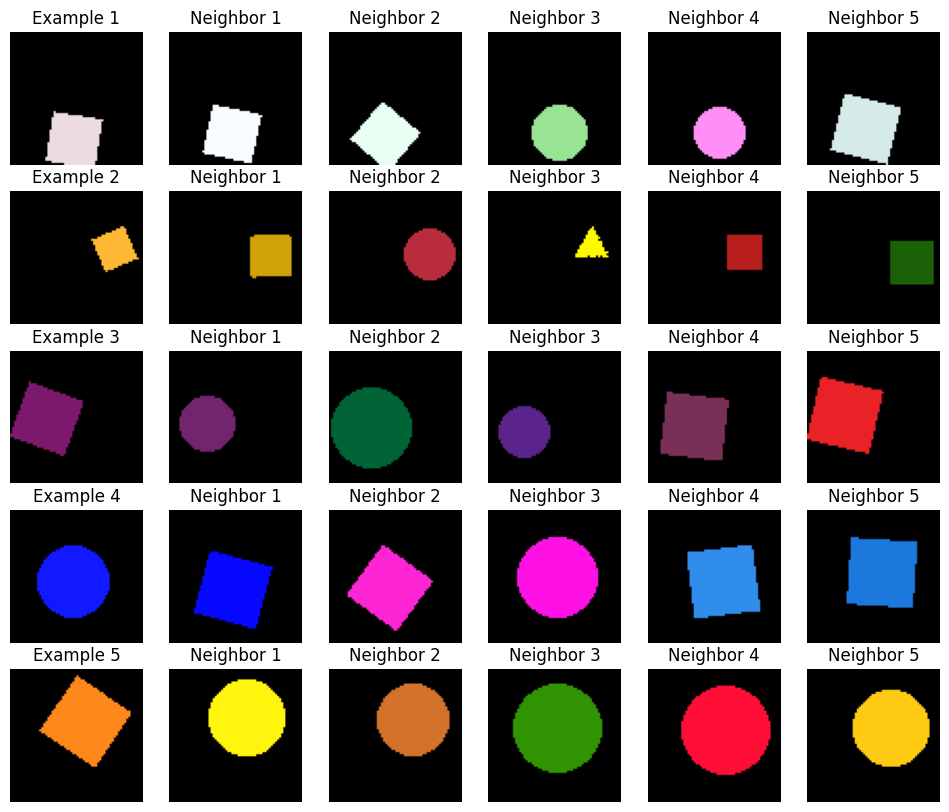

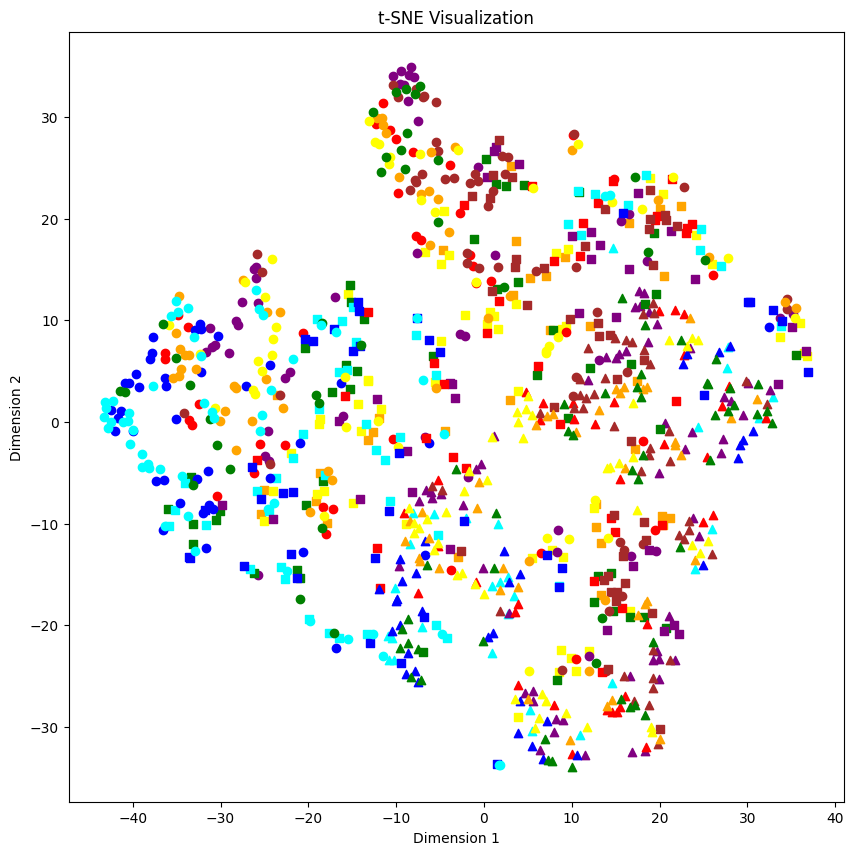

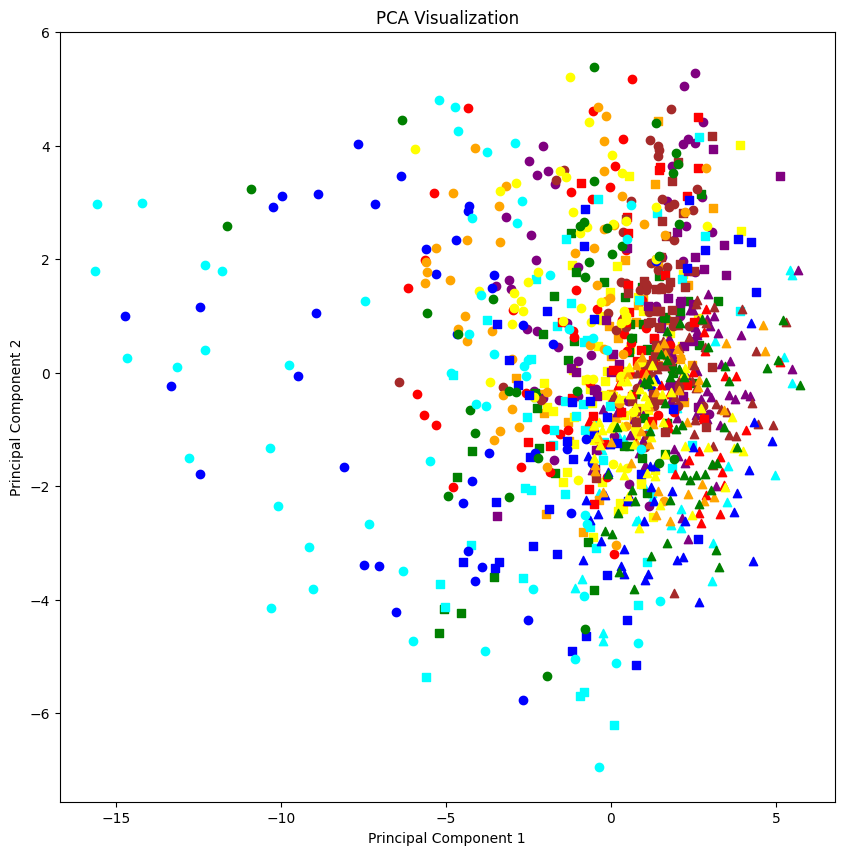

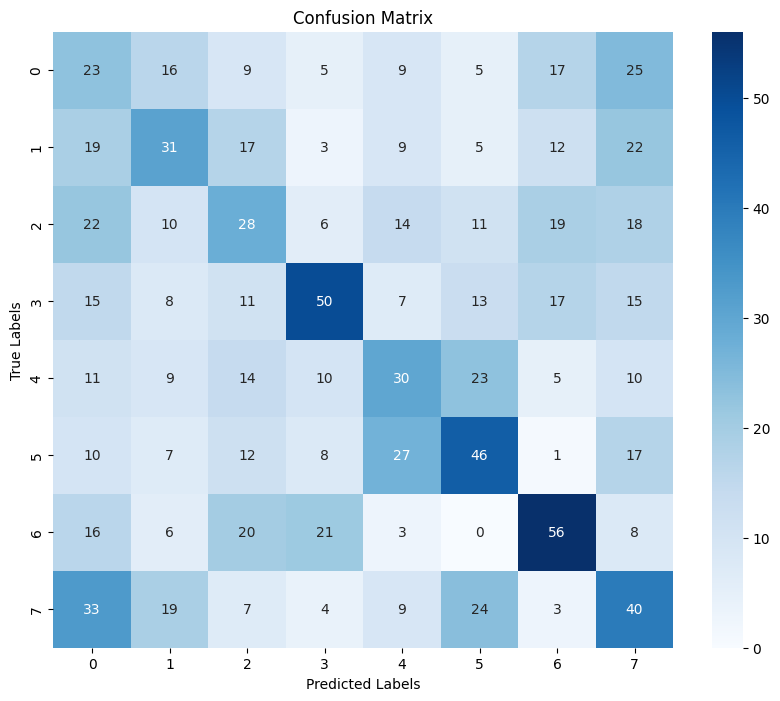

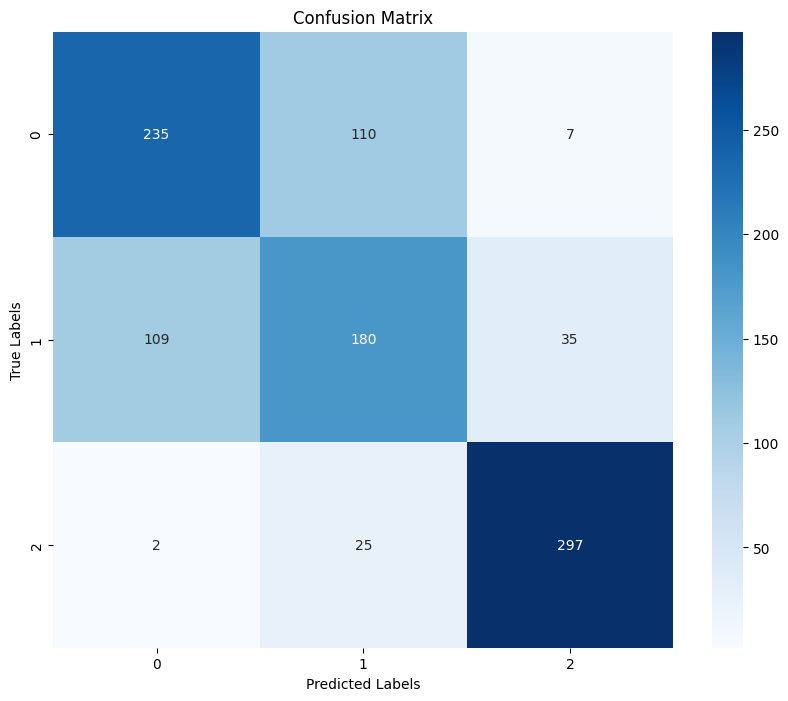

Silhouette Score: -0.14860019087791443
Cluster Purity: 0.207
Normalized Mutual Information (NMI): 0.28933075462368507


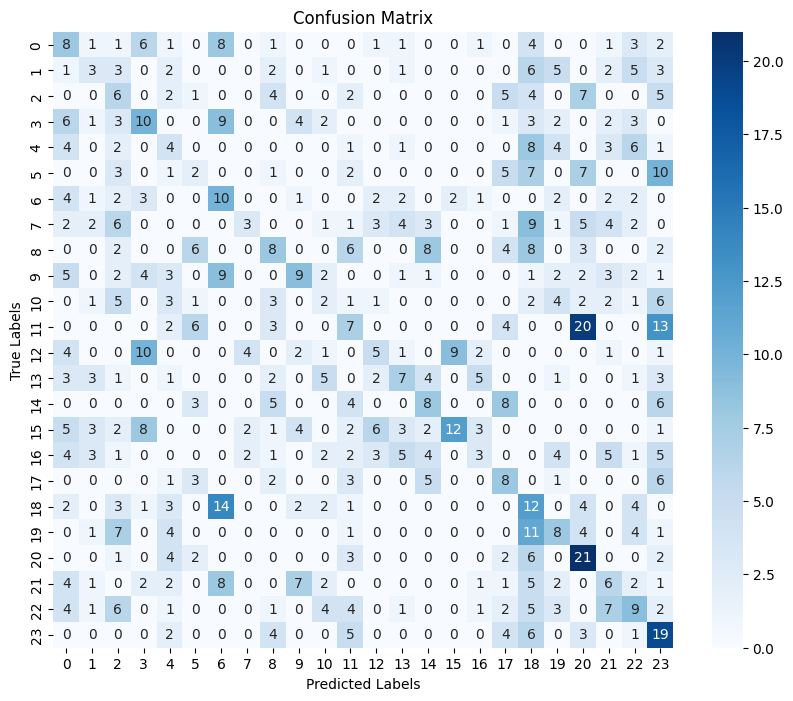

Silhouette Score: -0.09948713332414627
Cluster Purity: 0.218
Normalized Mutual Information (NMI): 0.07712758381370838


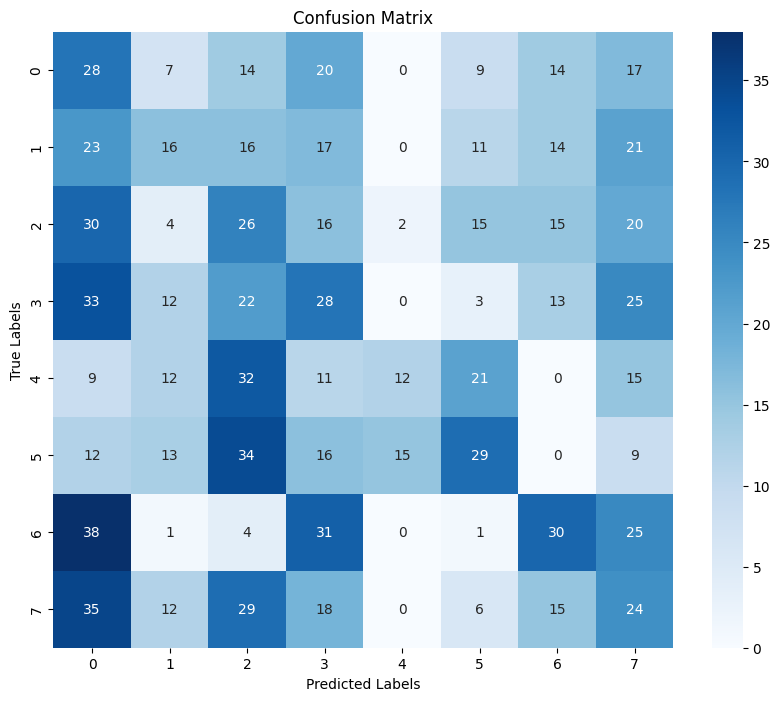

Silhouette Score: 0.0415174663066864
Cluster Purity: 0.453
Normalized Mutual Information (NMI): 0.09591244593234696


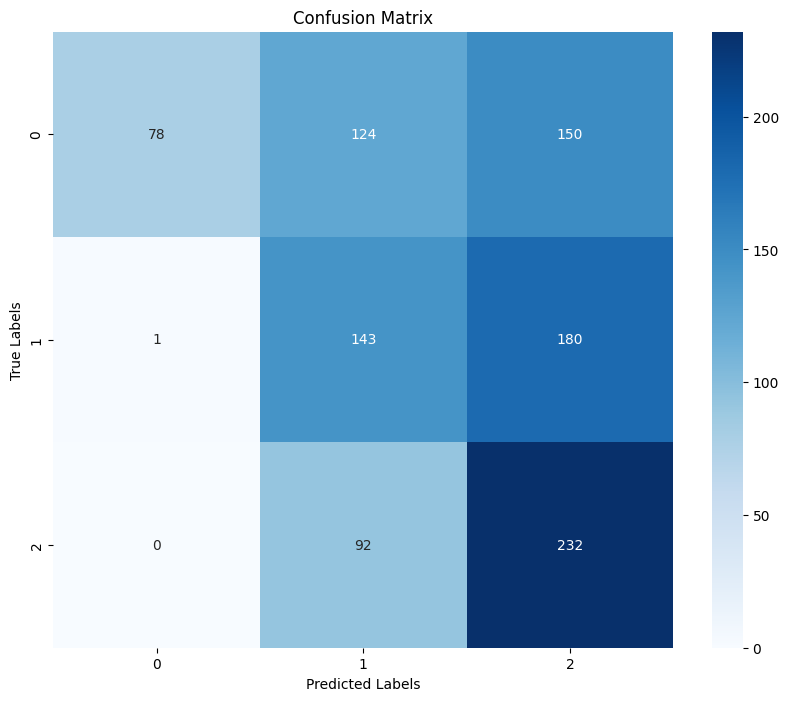

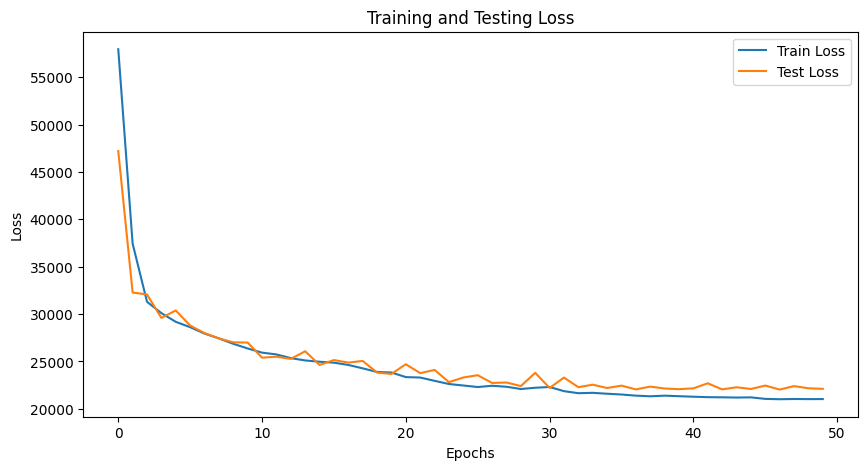

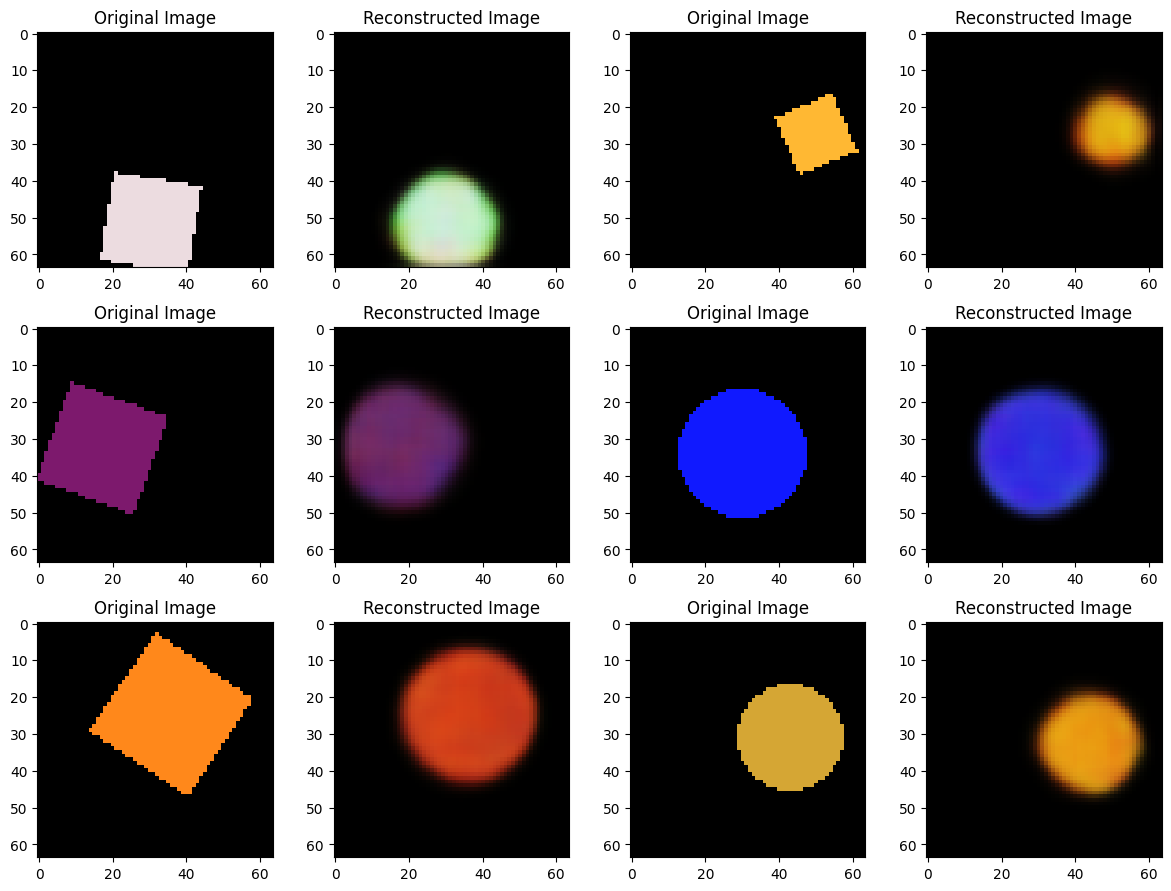

(AutoencoderWrapper(
   (model): Autoencoder(
     (encoder): Sequential(
       (0): ResidualBlock(
         (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
       )
       (1): Dropout(p=0.1, inplace=False)
       (2): ResidualBlock(
         (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       )
       (3): Dropout(p=0.1, inplace=False)
       (4): ResidualBlock(
         (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       )
       (5): Dropout(p=0.1, inplace=False)
       (6): ResidualBlock(
         (conv1): Co

In [4]:
train_model(embedding_size=4, dropout_rate=0.1)

Number of parameters: 1814579


/Users/criyle/project/cse5524/cse5524final/util.py:380: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:381: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.415
Shape Accuracy: 0.746
Combined Accuracy: 0.297


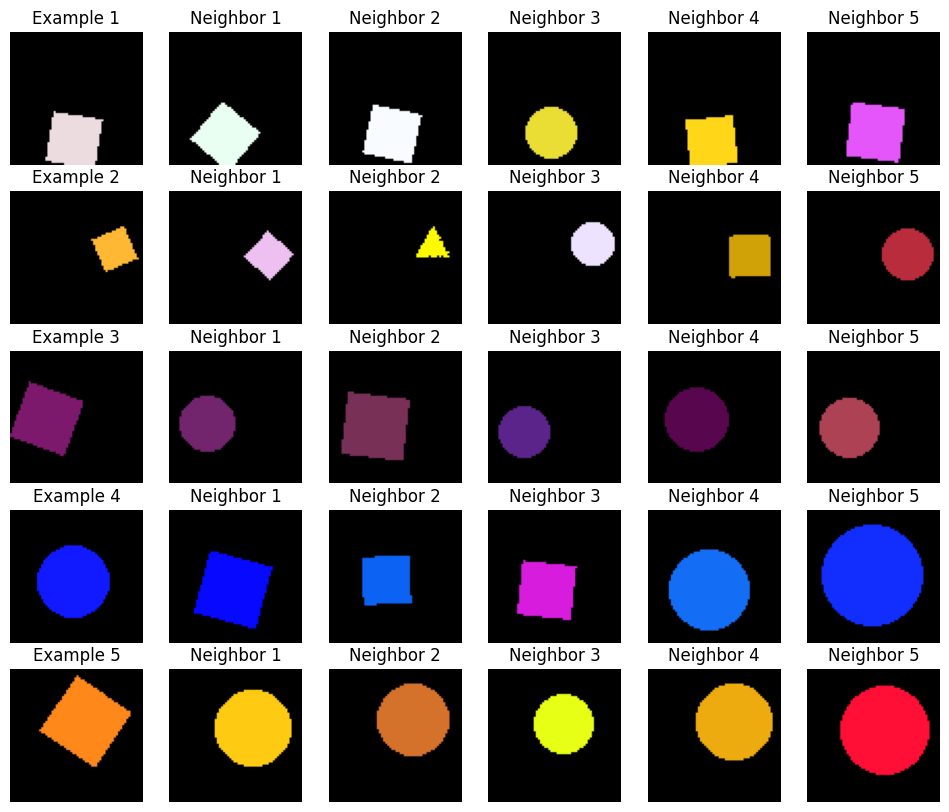

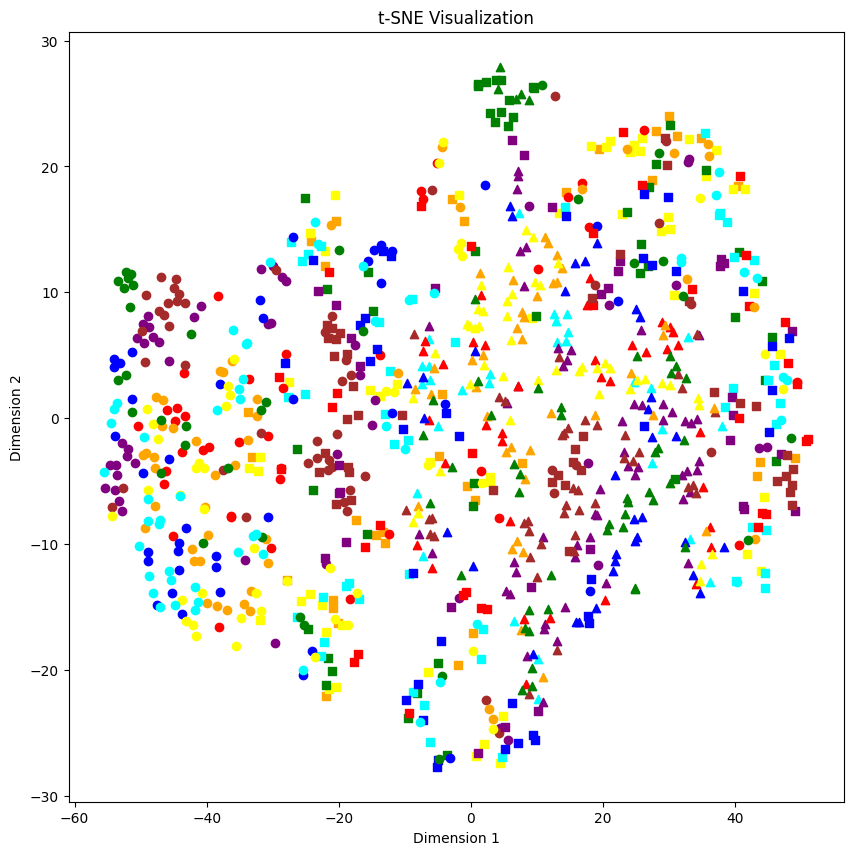

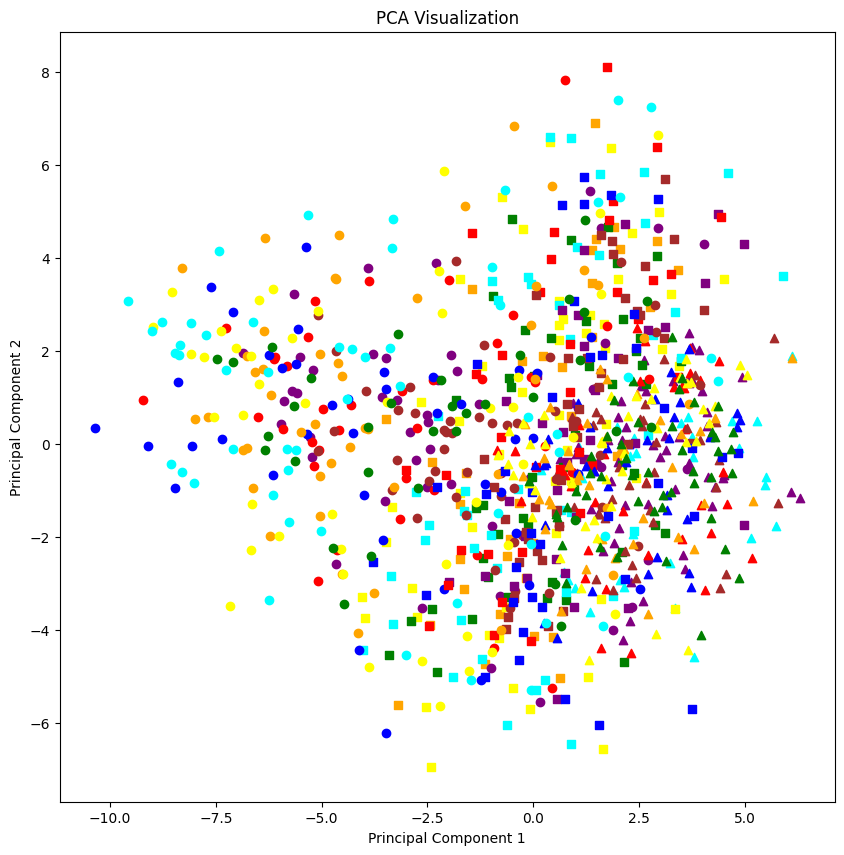

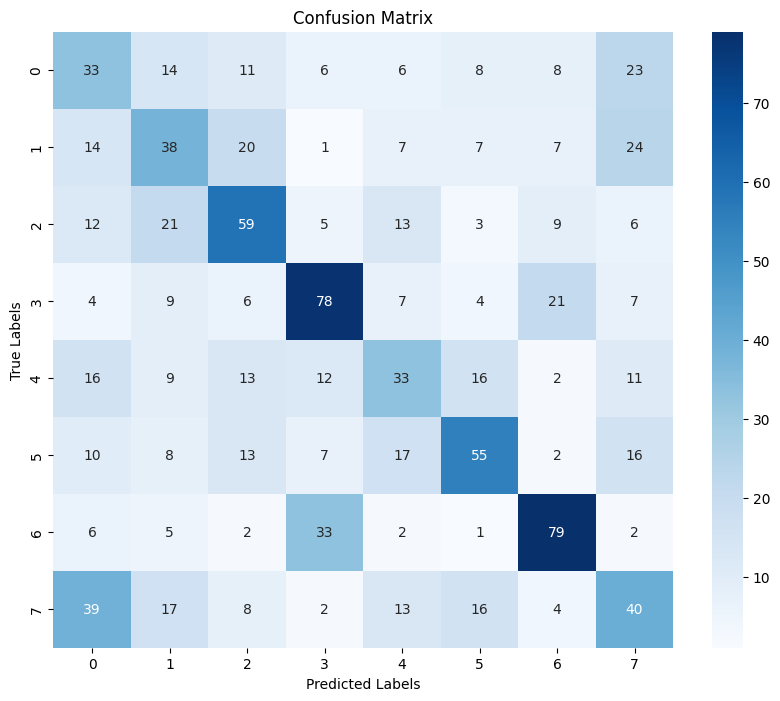

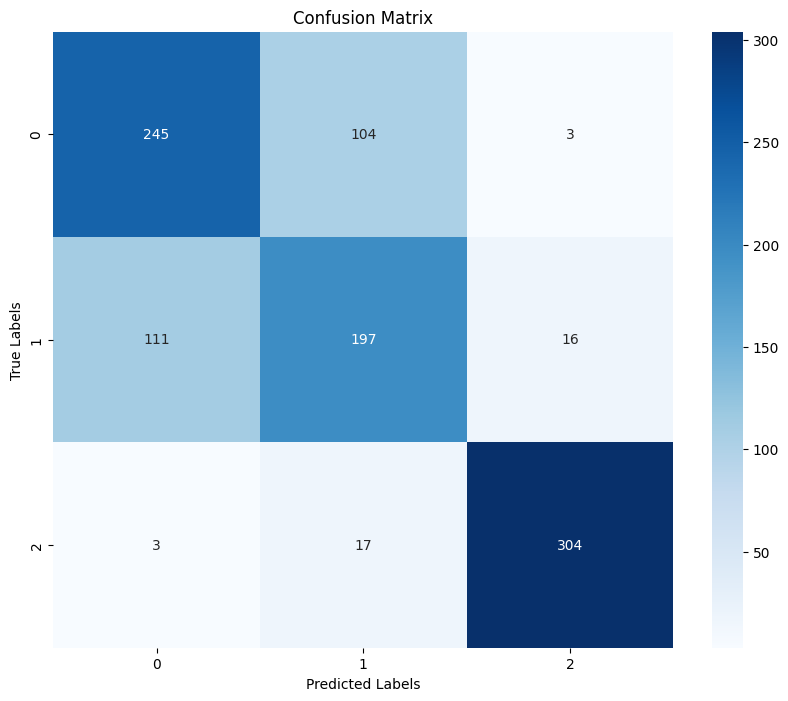

Silhouette Score: -0.09196698665618896
Cluster Purity: 0.212
Normalized Mutual Information (NMI): 0.2766702104444408


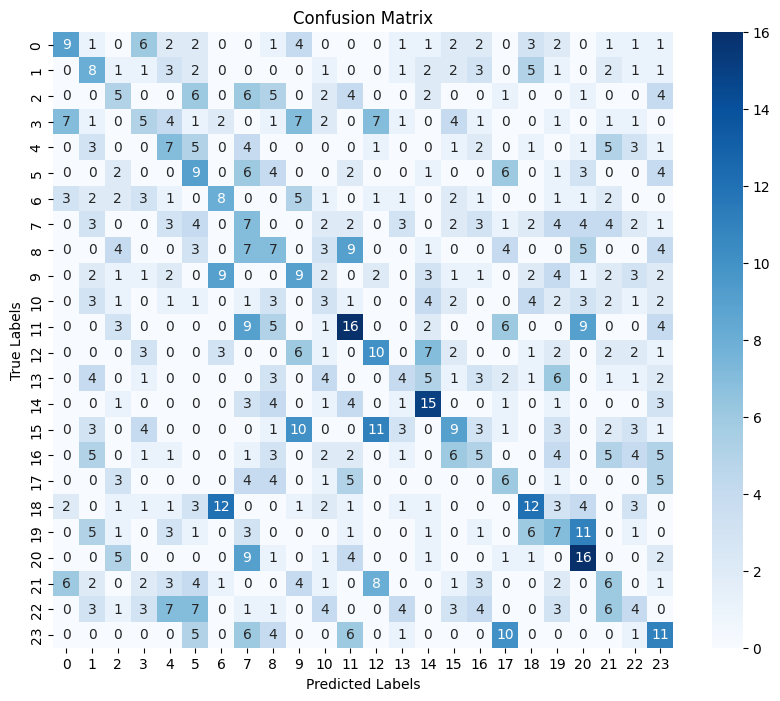

Silhouette Score: -0.052217911928892136
Cluster Purity: 0.207
Normalized Mutual Information (NMI): 0.04423064180014137


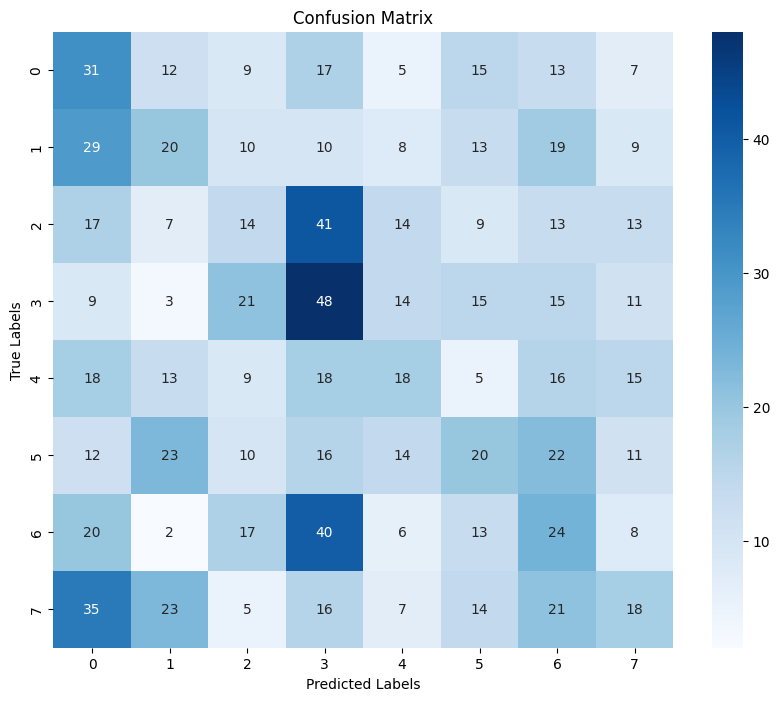

Silhouette Score: 0.051564086228609085
Cluster Purity: 0.534
Normalized Mutual Information (NMI): 0.22049686977696353


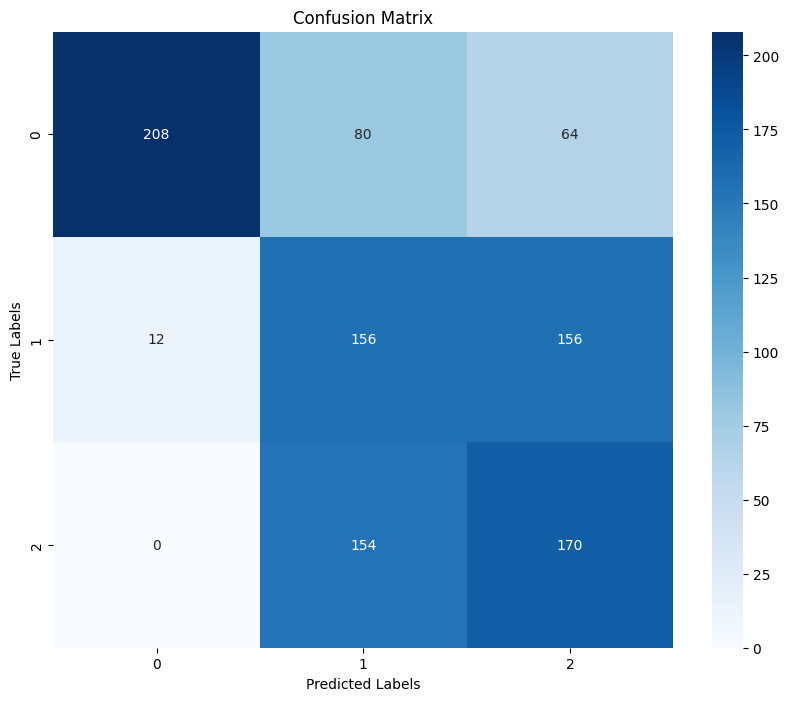

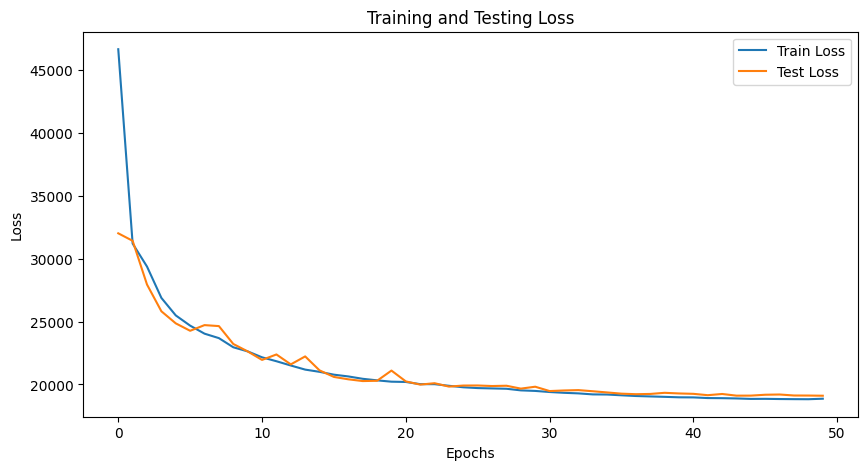

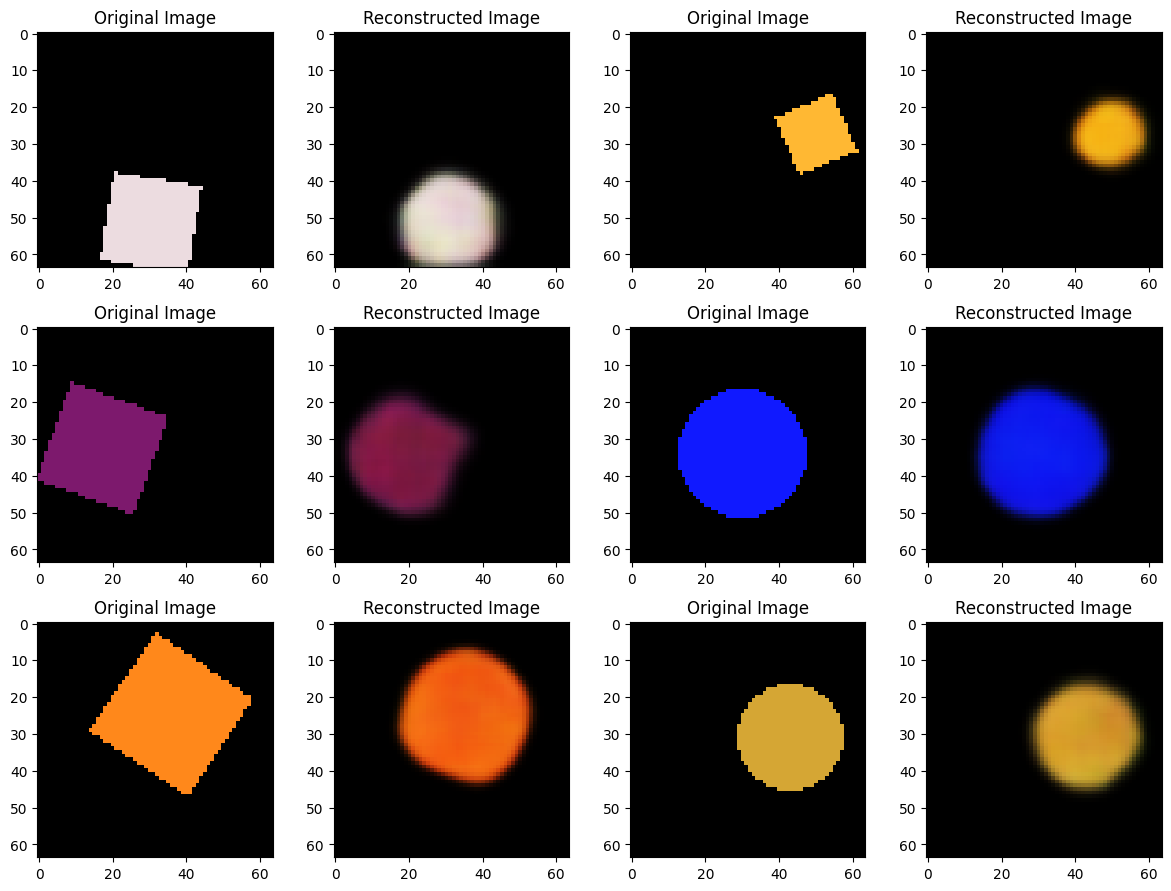

(AutoencoderWrapper(
   (model): Autoencoder(
     (encoder): Sequential(
       (0): ResidualBlock(
         (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
       )
       (1): Dropout(p=0.1, inplace=False)
       (2): ResidualBlock(
         (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       )
       (3): Dropout(p=0.1, inplace=False)
       (4): ResidualBlock(
         (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       )
       (5): Dropout(p=0.1, inplace=False)
       (6): ResidualBlock(
         (conv1): Co

In [5]:
train_model(embedding_size=8, dropout_rate=0.1)

Number of parameters: 2011203


/Users/criyle/project/cse5524/cse5524final/util.py:380: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:381: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.345
Shape Accuracy: 0.822
Combined Accuracy: 0.278


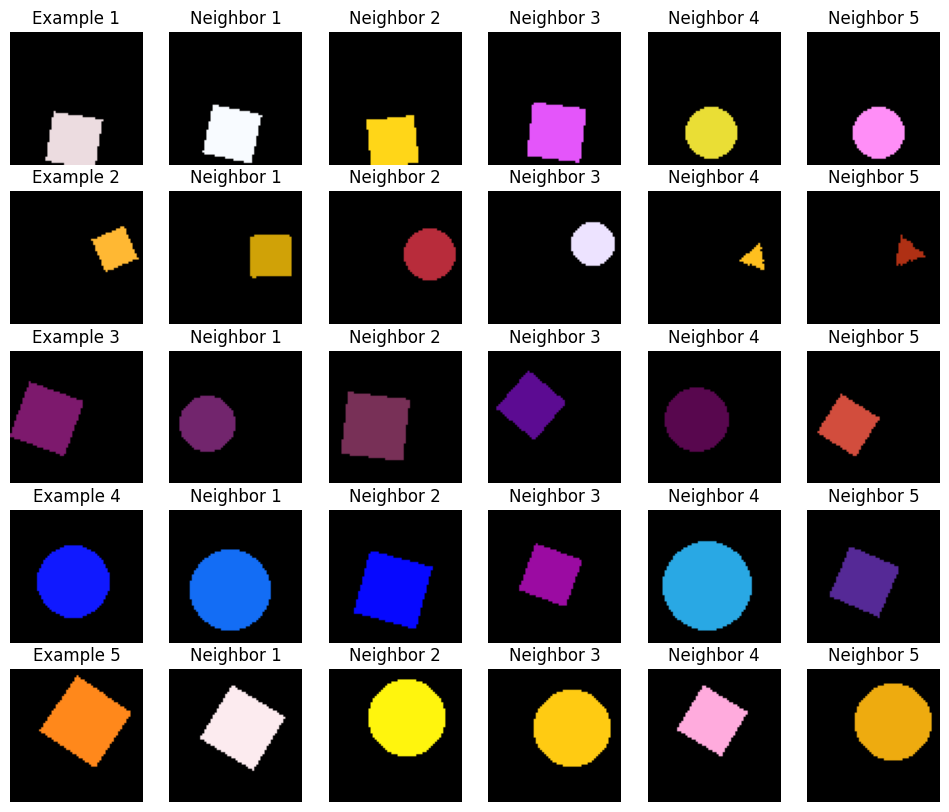

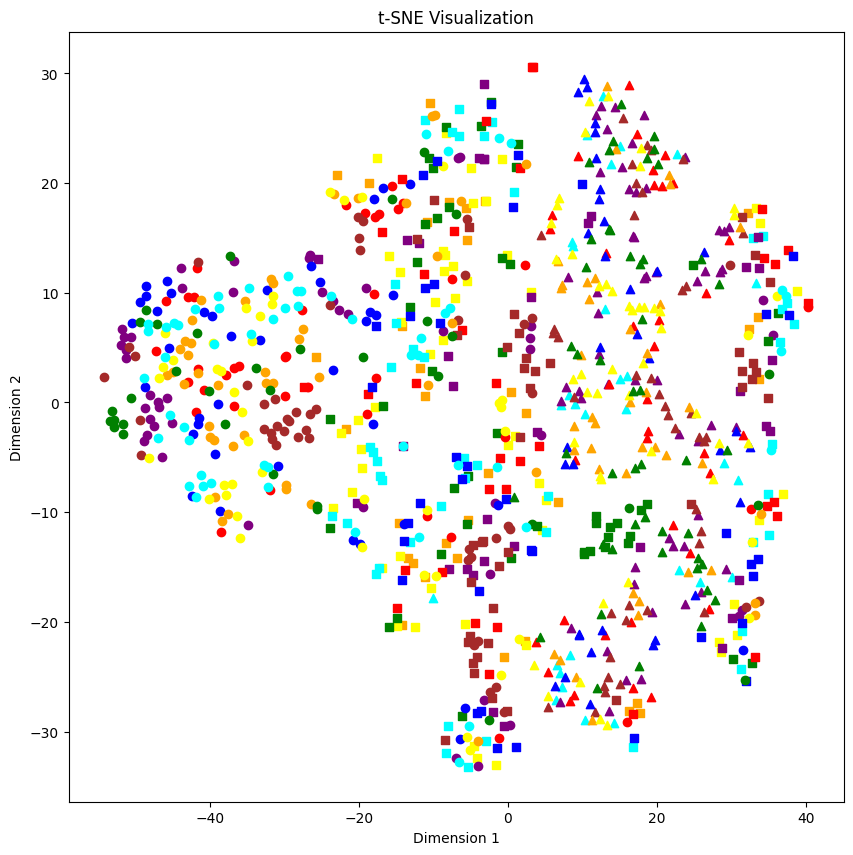

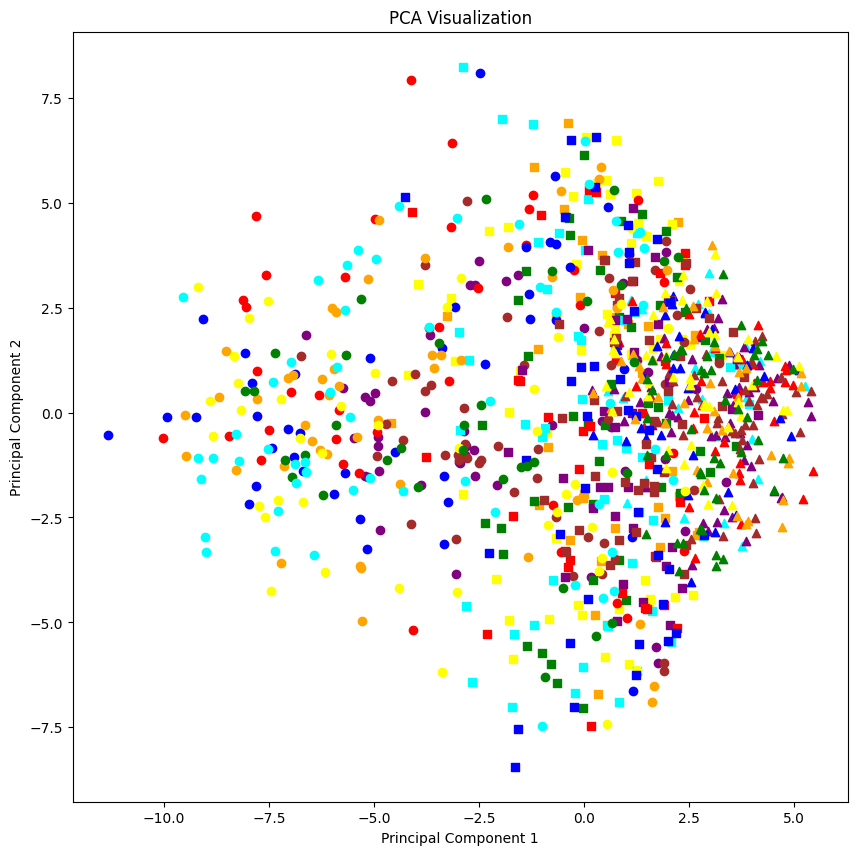

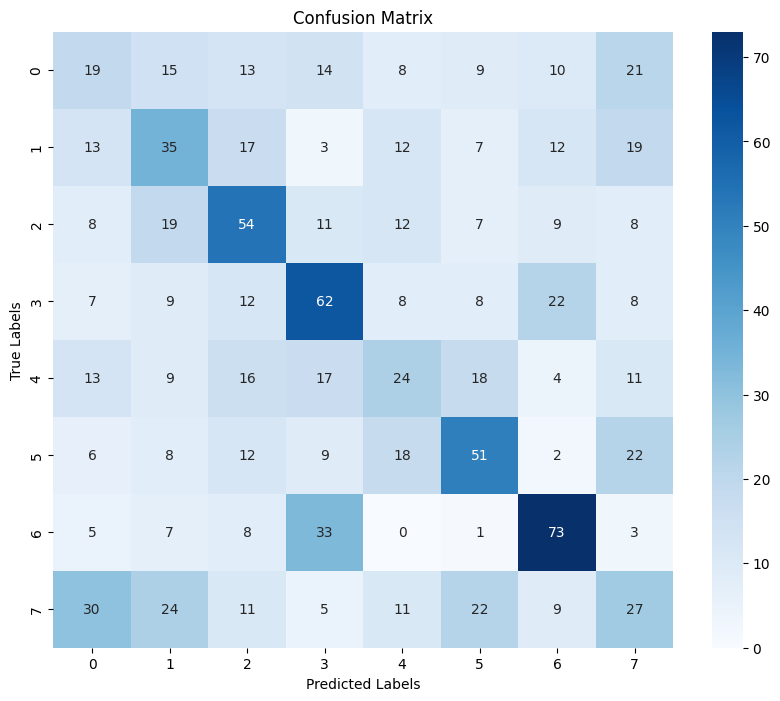

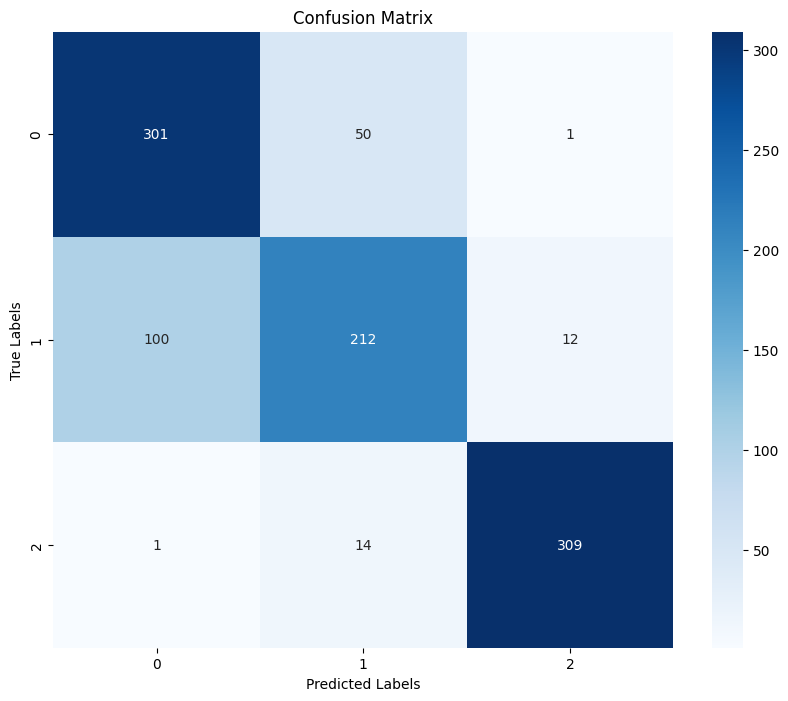

Silhouette Score: -0.07419651746749878
Cluster Purity: 0.195
Normalized Mutual Information (NMI): 0.2698911511337227


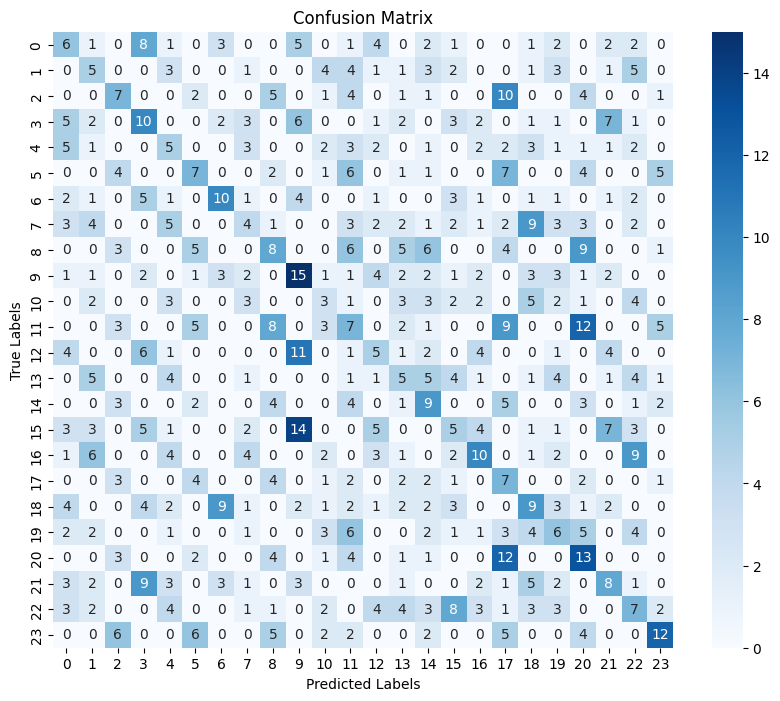

Silhouette Score: -0.05172906443476677
Cluster Purity: 0.178
Normalized Mutual Information (NMI): 0.016527019683351726


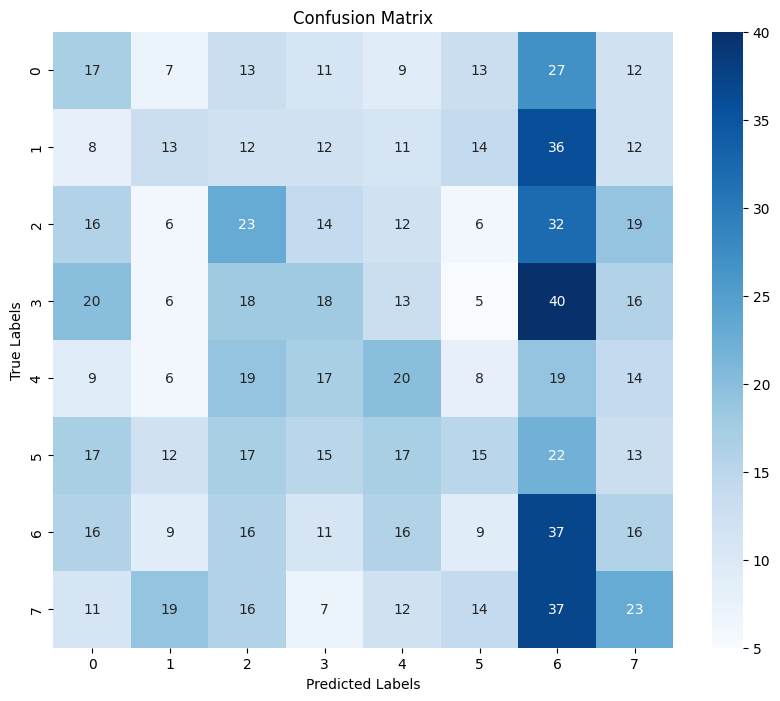

Silhouette Score: 0.051933277398347855
Cluster Purity: 0.569
Normalized Mutual Information (NMI): 0.22019516815604093


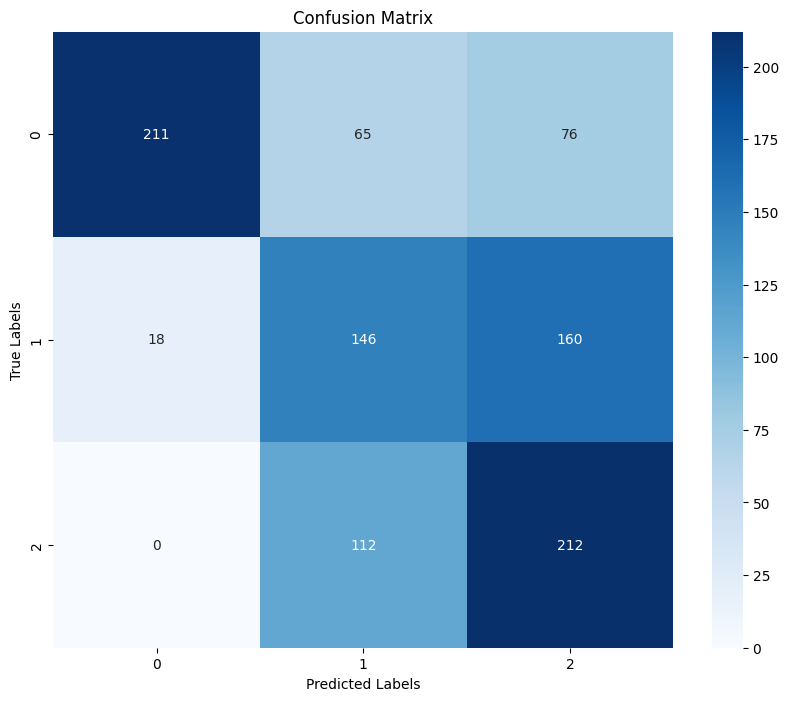

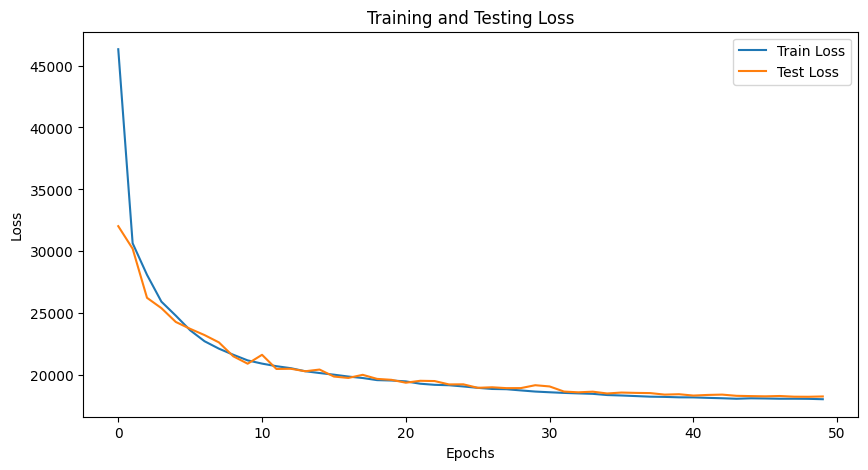

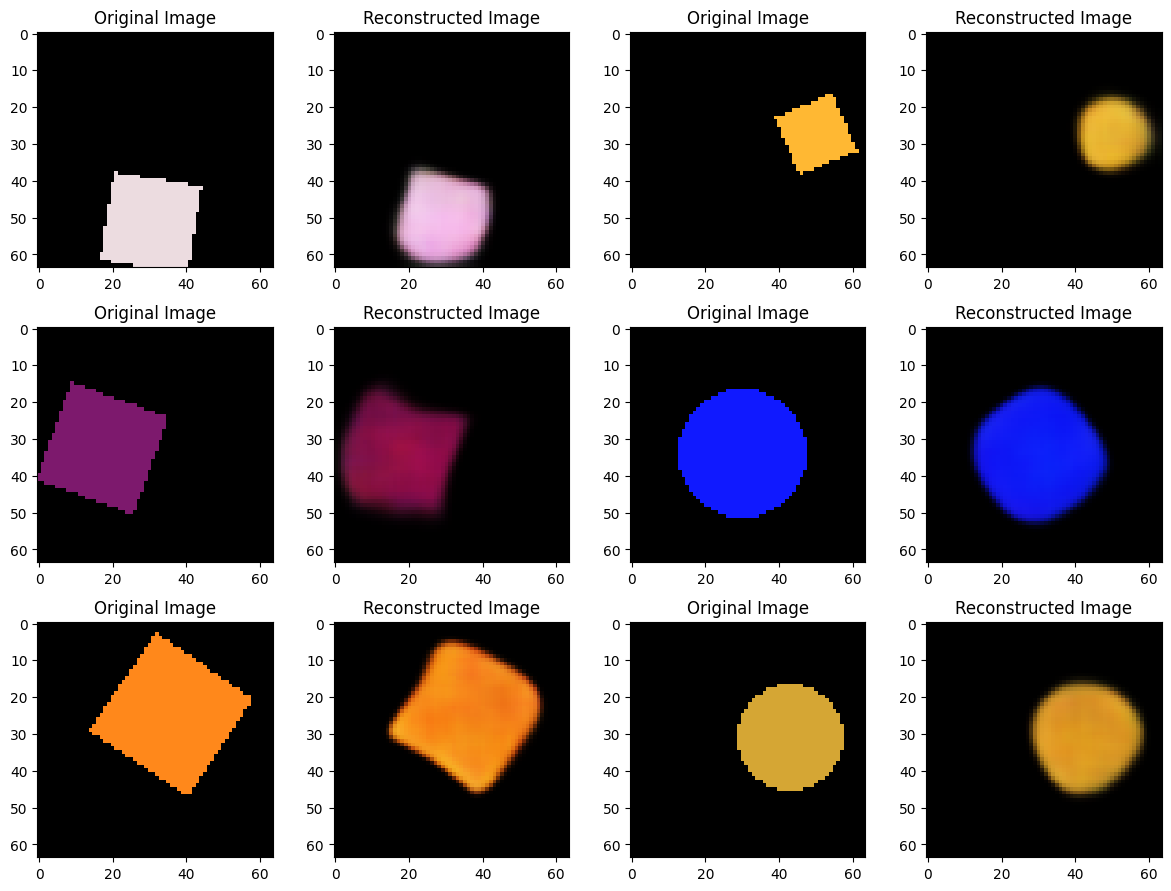

(AutoencoderWrapper(
   (model): Autoencoder(
     (encoder): Sequential(
       (0): ResidualBlock(
         (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
       )
       (1): Dropout(p=0.1, inplace=False)
       (2): ResidualBlock(
         (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       )
       (3): Dropout(p=0.1, inplace=False)
       (4): ResidualBlock(
         (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       )
       (5): Dropout(p=0.1, inplace=False)
       (6): ResidualBlock(
         (conv1): Co

In [6]:
train_model(embedding_size=16, dropout_rate=0.1)

Number of parameters: 2404451


/Users/criyle/project/cse5524/cse5524final/util.py:380: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:381: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.324
Shape Accuracy: 0.845
Combined Accuracy: 0.267


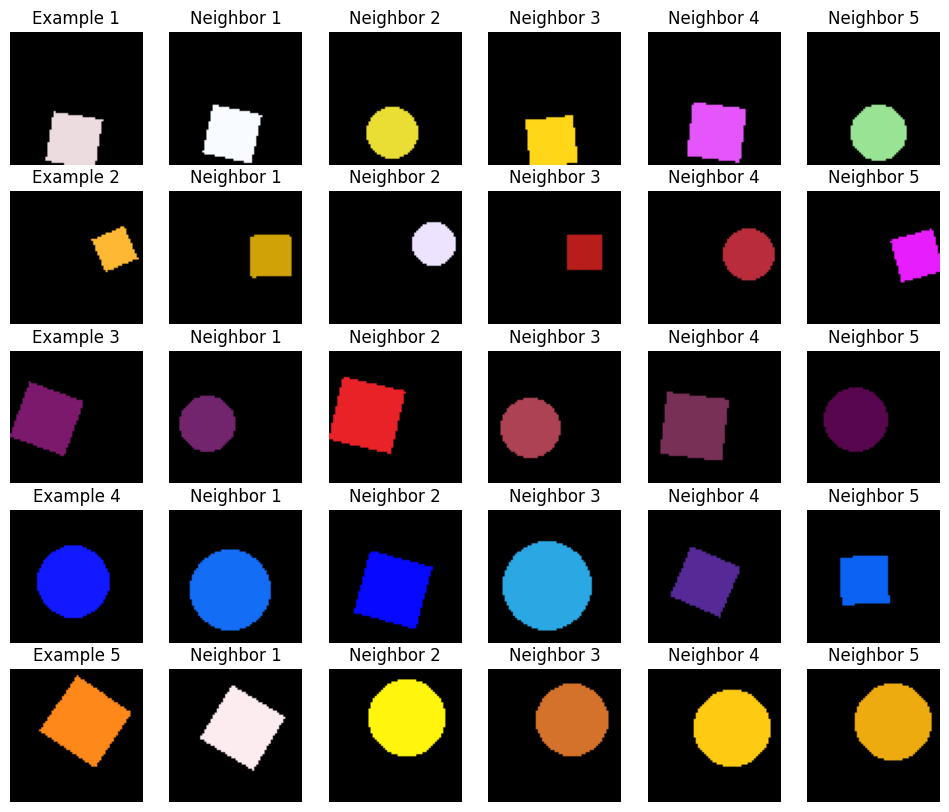

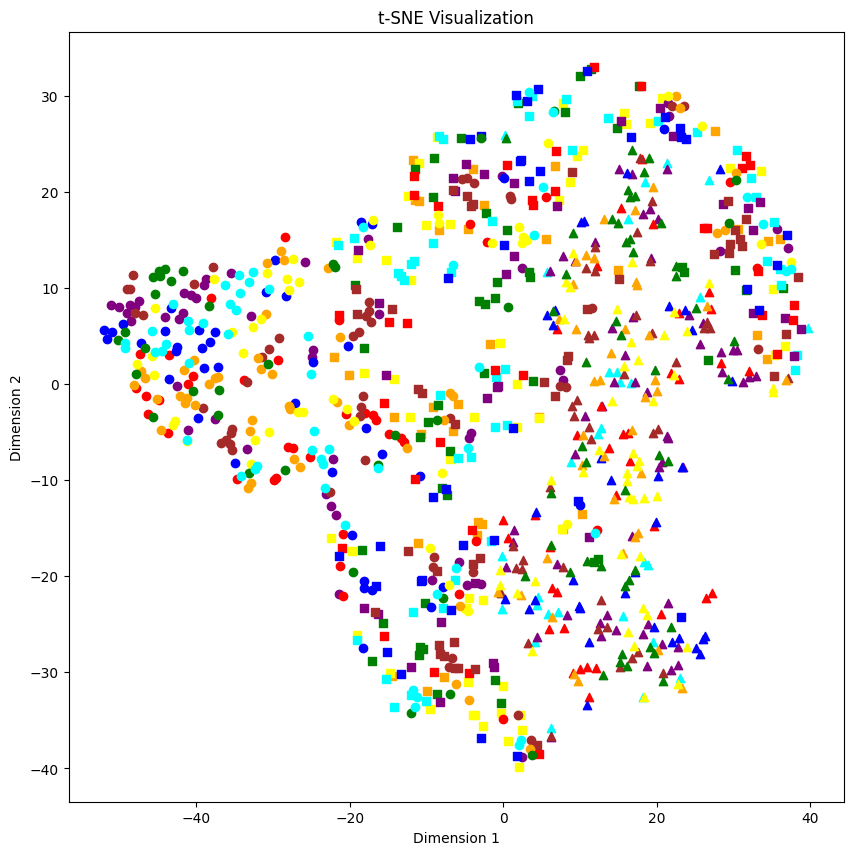

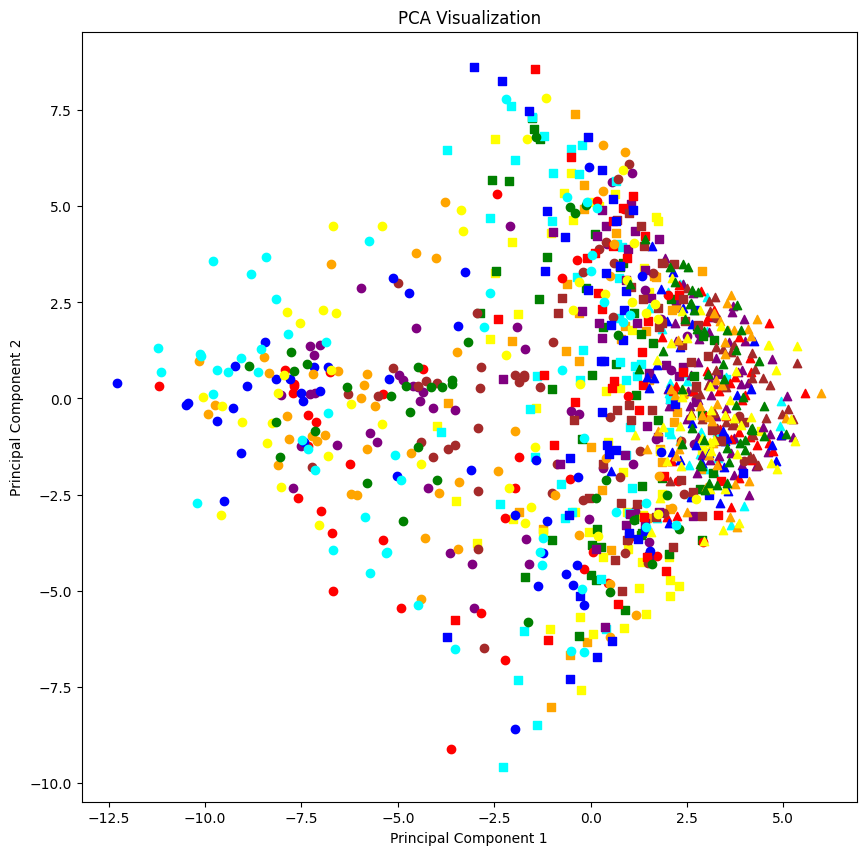

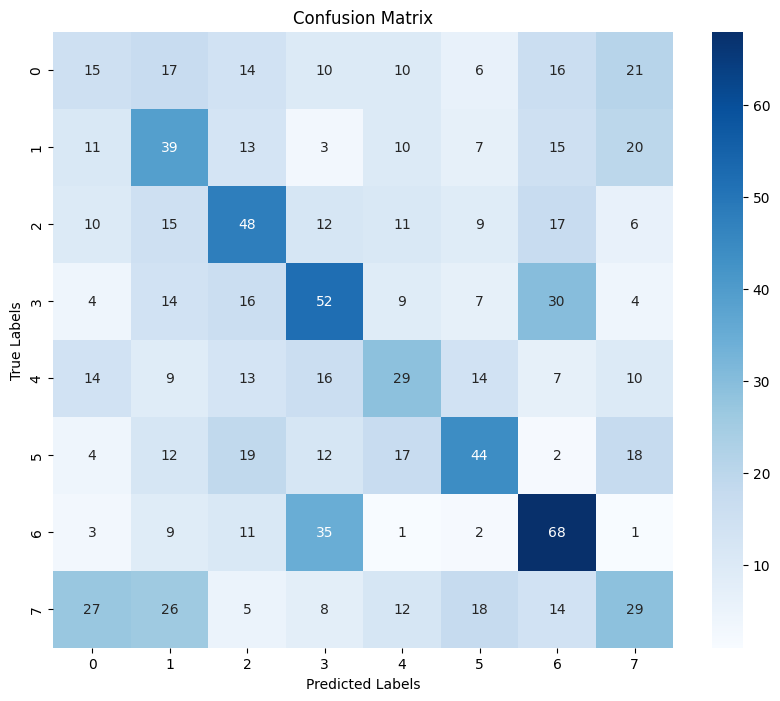

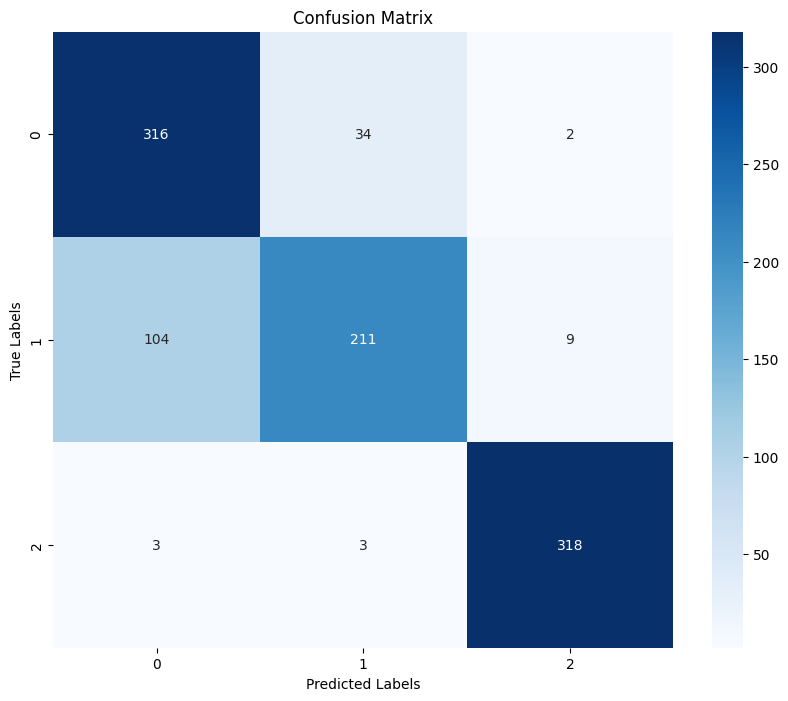

Silhouette Score: -0.08016621321439743
Cluster Purity: 0.177
Normalized Mutual Information (NMI): 0.2516694820850913


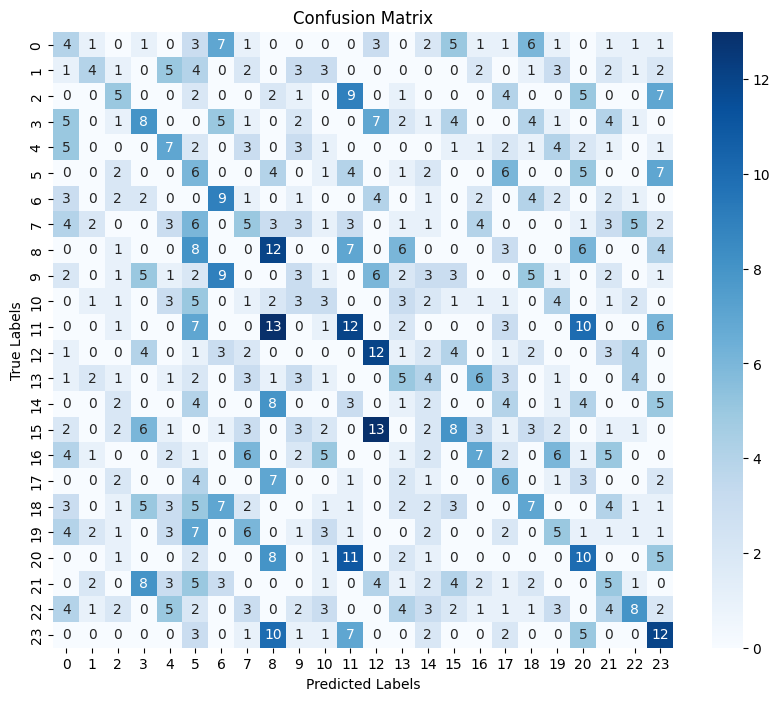

Silhouette Score: -0.058580443263053894
Cluster Purity: 0.183
Normalized Mutual Information (NMI): 0.015035096750686252


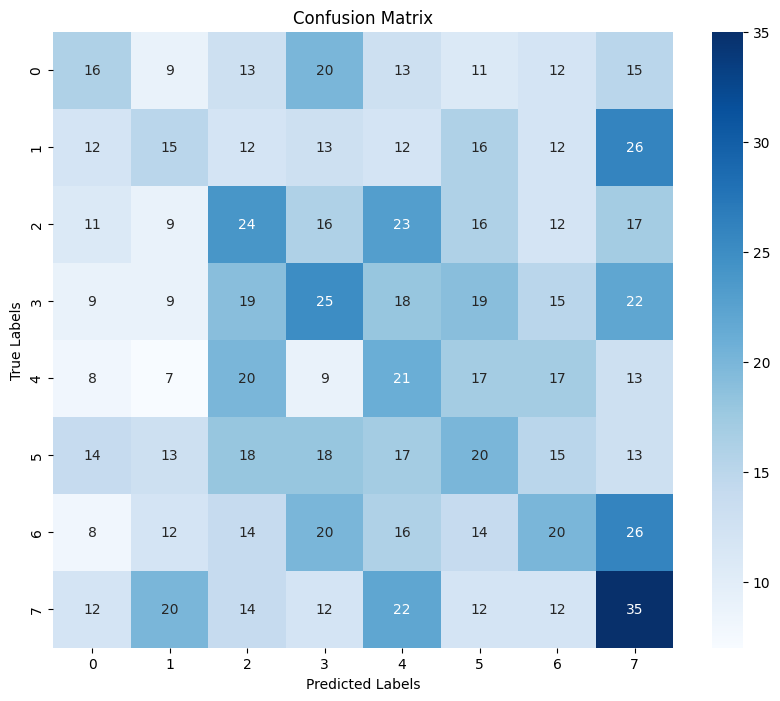

Silhouette Score: 0.04582584649324417
Cluster Purity: 0.577
Normalized Mutual Information (NMI): 0.22394929263855734


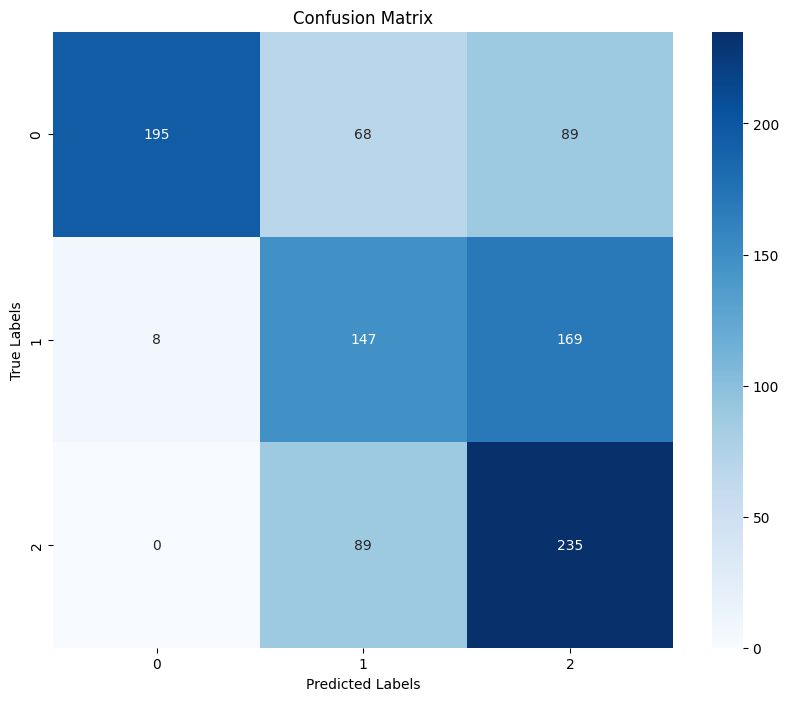

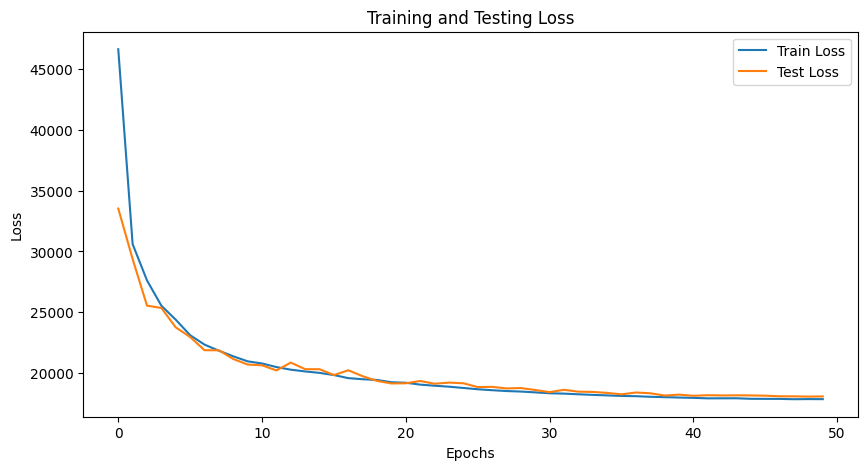

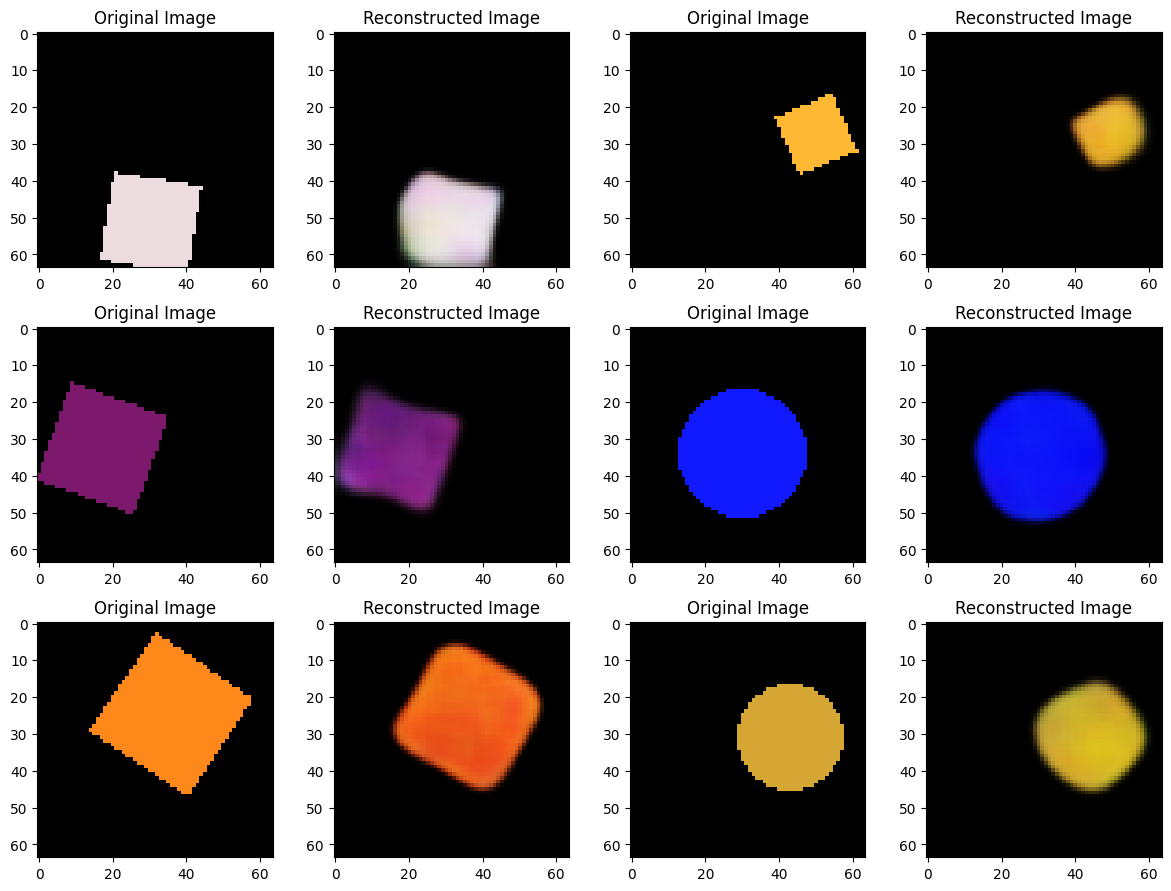

(AutoencoderWrapper(
   (model): Autoencoder(
     (encoder): Sequential(
       (0): ResidualBlock(
         (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
       )
       (1): Dropout(p=0.1, inplace=False)
       (2): ResidualBlock(
         (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       )
       (3): Dropout(p=0.1, inplace=False)
       (4): ResidualBlock(
         (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       )
       (5): Dropout(p=0.1, inplace=False)
       (6): ResidualBlock(
         (conv1): Co

In [7]:
train_model(embedding_size=32, dropout_rate=0.1)

Number of parameters: 3190947


/Users/criyle/project/cse5524/cse5524final/util.py:380: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:381: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.32
Shape Accuracy: 0.833
Combined Accuracy: 0.256


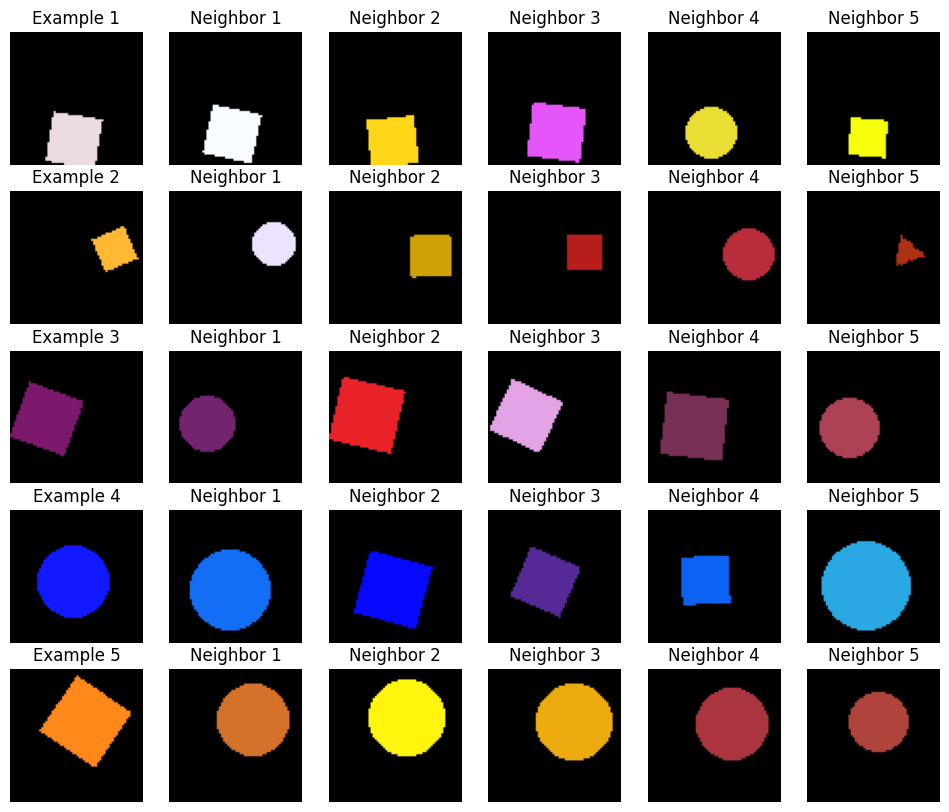

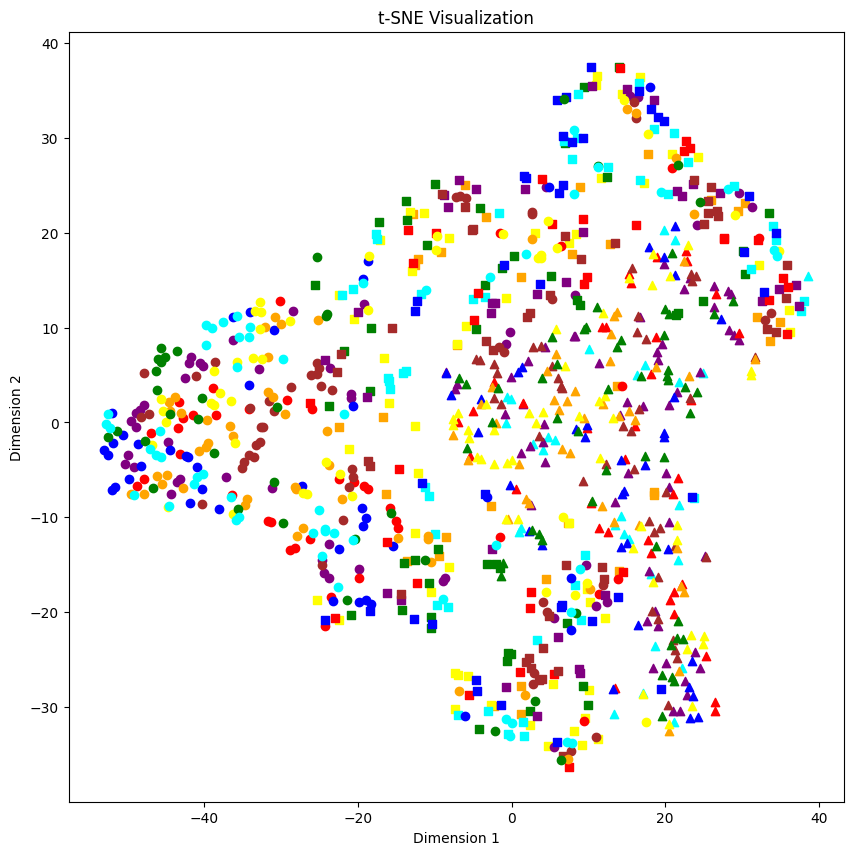

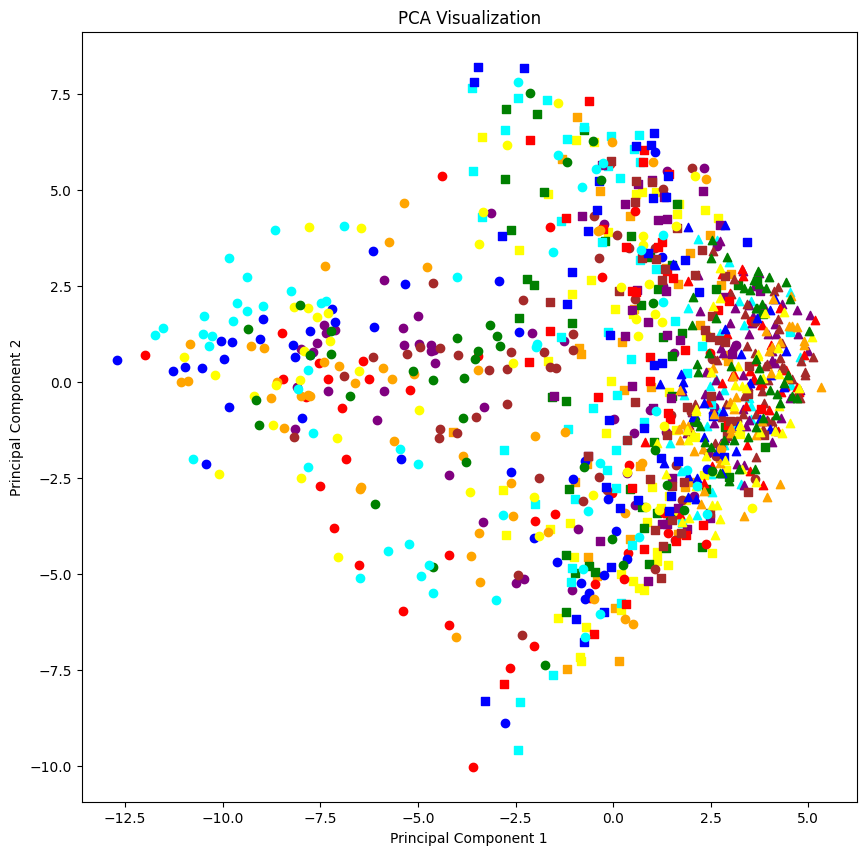

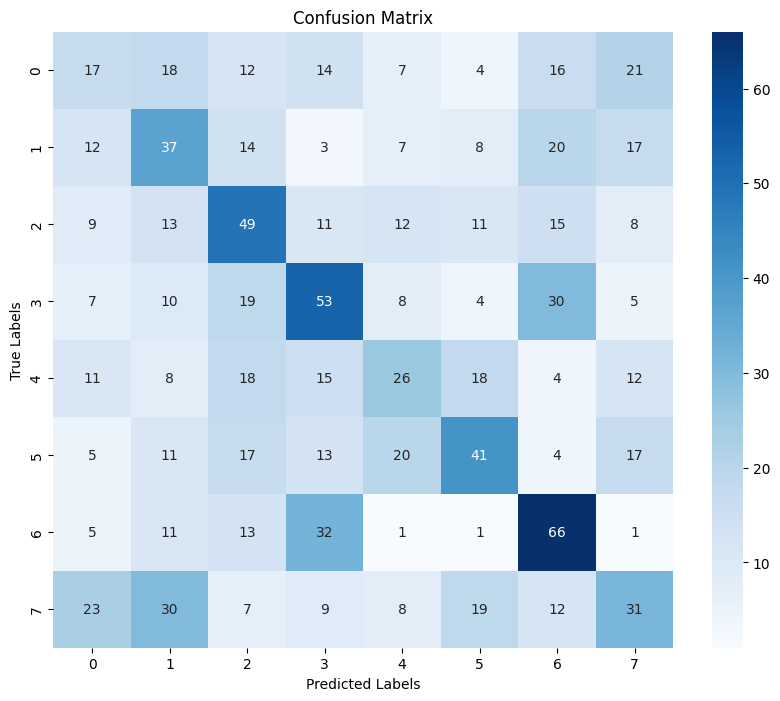

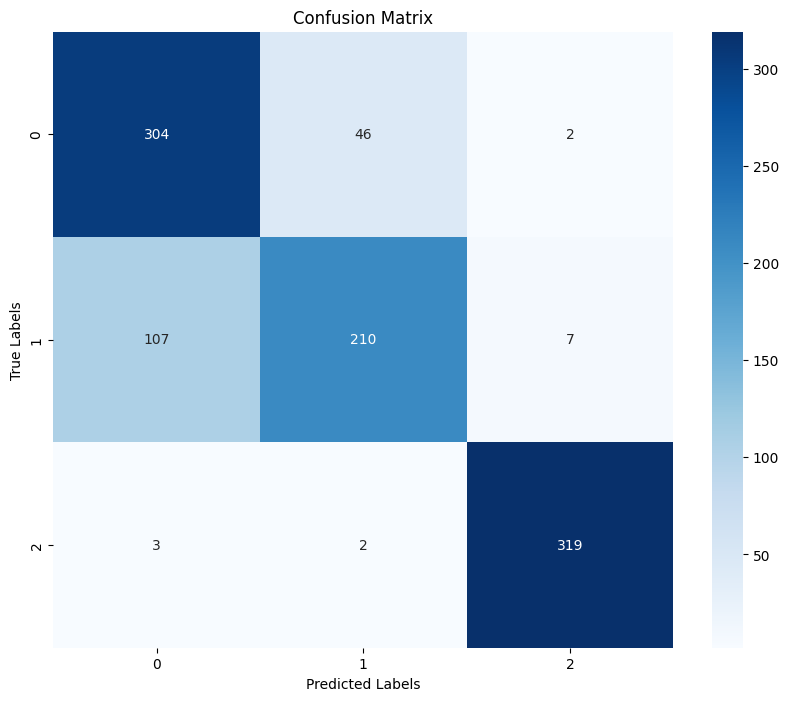

Silhouette Score: -0.08088043332099915
Cluster Purity: 0.197
Normalized Mutual Information (NMI): 0.26801033979257777


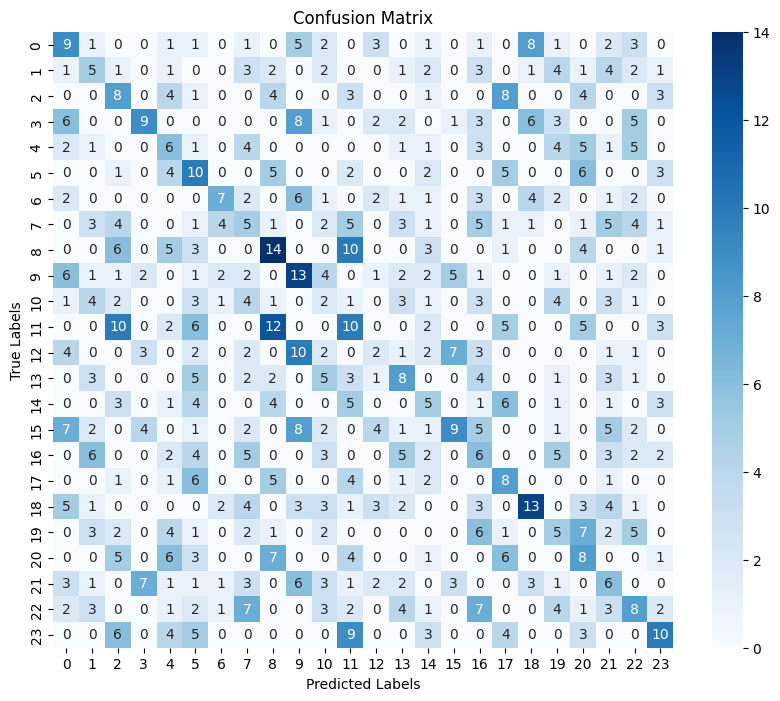

Silhouette Score: -0.05428249388933182
Cluster Purity: 0.178
Normalized Mutual Information (NMI): 0.016177224553685157


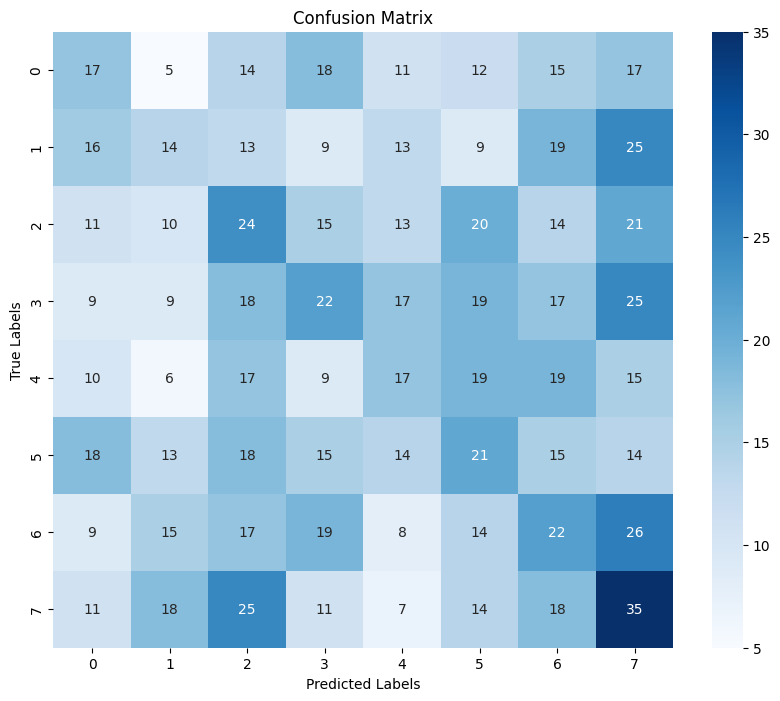

Silhouette Score: 0.03182020038366318
Cluster Purity: 0.507
Normalized Mutual Information (NMI): 0.21006418504670357


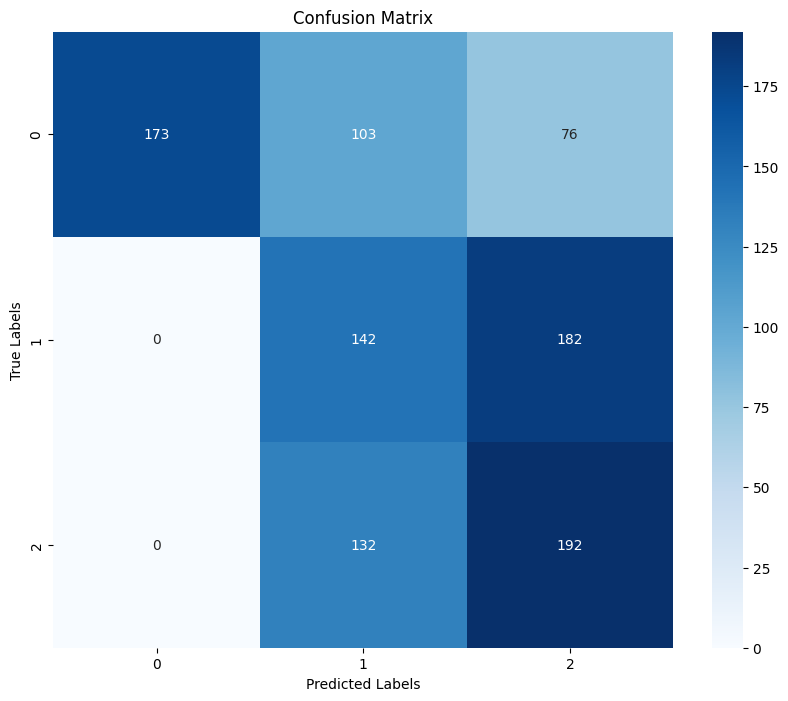

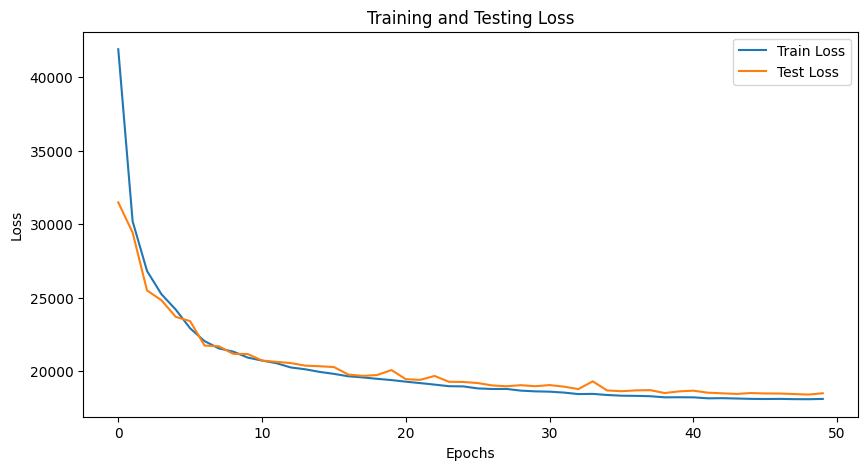

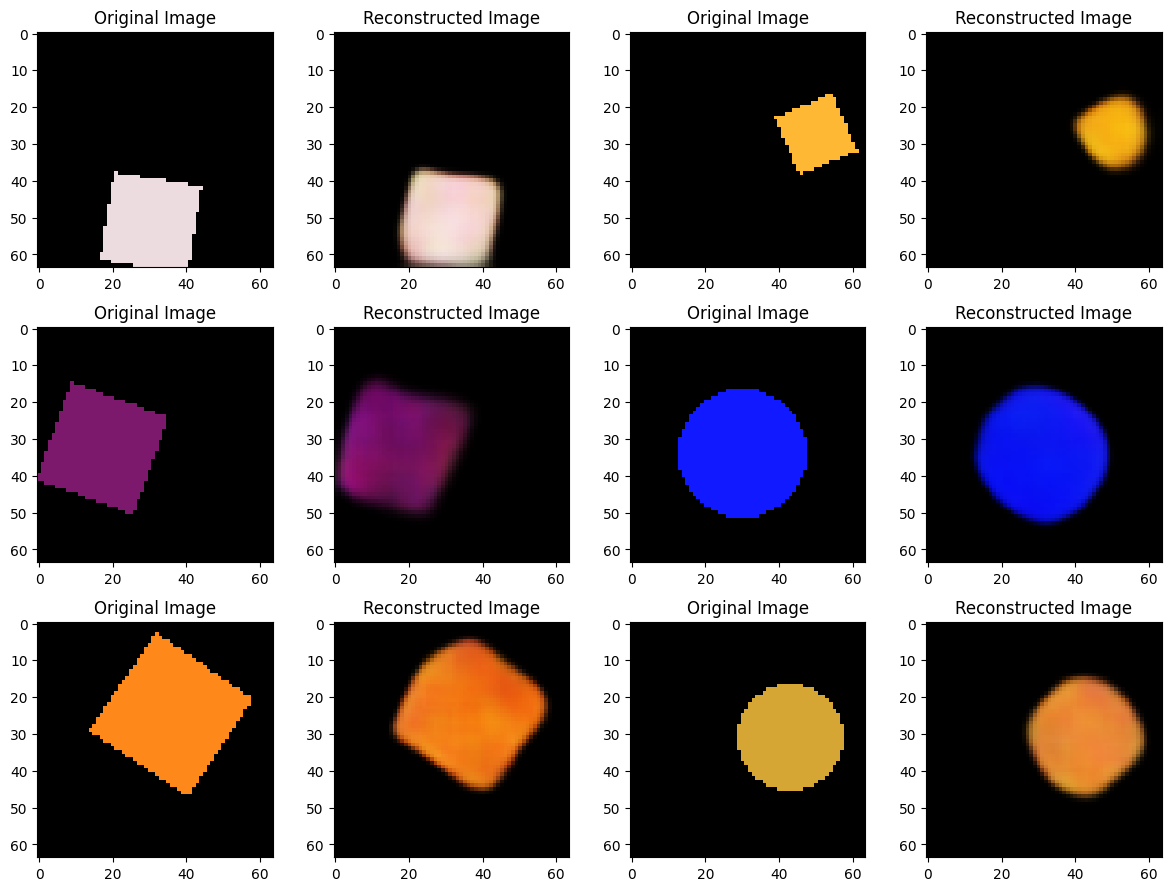

(AutoencoderWrapper(
   (model): Autoencoder(
     (encoder): Sequential(
       (0): ResidualBlock(
         (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
       )
       (1): Dropout(p=0.1, inplace=False)
       (2): ResidualBlock(
         (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       )
       (3): Dropout(p=0.1, inplace=False)
       (4): ResidualBlock(
         (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (relu): ReLU()
         (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       )
       (5): Dropout(p=0.1, inplace=False)
       (6): ResidualBlock(
         (conv1): Co

In [8]:
train_model(embedding_size=64, dropout_rate=0.1)

In [9]:
print(accuracy)

{4: (304, 712, 214), 8: (415, 746, 297), 16: (345, 822, 278), 32: (324, 845, 267), 64: (320, 833, 256)}
